In [66]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

In [67]:
# block to setup BQ
import os
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

os.environ['GOOGLE_APPLICATION_CREDENTIALS']=f"/home/jovyan/.config/gcloud/legacy_credentials/{os.getenv('JUPYTERHUB_USER')}/adc.json" 

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)

# Make clients.
bqclient = bigquery.Client(credentials=credentials, project='wx-bq-poc',)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

# build comparison code
* compare normalised prob
* compare inc sales (default to email as well as others)

In [75]:
def convert_to_post_MTA_format(fpath_results,
                               campaign_code,
                               fw,
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final`",
                               rm_fb=True,
                               create_dacamp_prod_mc_final=False):
    """
    Overview
        Convert output from MTA package into post MC format in Safari (for downstream processing to MC CRN level).
        Saves to BQ.
    Arguments
        fpath_results - filepath to CSV with channel attribution, MTA package output
        campaign_code - e.g. "CVM-1661"
        fw - financial week, e.g. "2021-04-12"
        dacamp_prod_mc_final - where to save MC attribution in post MTA format, BQ table
    Returns
        table saved to BQ
    """
    df = pd.read_csv(fpath_results)
    
    print("\tremoving facebook touchpoints from MC output")
    if rm_fb:  # rm fb touchpoints and rescale everything back up to 100%
        conversion_value_fb = df.loc[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression"), "normalised_conversion_value"].sum()
        conversion_value_non_fb = df.loc[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression"), "normalised_conversion_value"].sum()
        scaling = 1 / conversion_value_non_fb
        df.loc[:, "normalised_conversion_value"] = scaling * df.loc[:, "normalised_conversion_value"]
        df = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")]

    
    df = df.drop("Unnamed: 0", axis="columns")

    df.loc[:, "event"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 0]
    df.loc[:, "campaign_start_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 1]
    df.loc[:, "campaign_end_date"] = df.channel_name.str.extract(r"(.*)_(\d{4}-\d{2}-\d{2})_(\d{4}-\d{2}-\d{2})").iloc[:, 2]

    # extract channel, medium, event from full MC node name
    event_extract = df.channel_name.str.extract(r"({campaign_code}|_AlwaysOn)_(display|email|rw_app|google_other|sem|wow_web)(_brand|_generic|_other|_shopping)?_(clk|open|imp|view)".format(campaign_code=campaign_code)).fillna("")
    event_extract

    df.loc[:, "channel"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1]
    df.loc[:, "medium"] = event_extract.iloc[:, 0] + "_" + event_extract.iloc[:, 1] + event_extract.iloc[:, 2]
   
    df.loc[:, "key"] = "Total_supermarkets_" + campaign_code + "_" + df.loc[:, "campaign_start_date"] + '_' + df.loc[:, "campaign_end_date"]
    df.loc[:, "banner"] = "supermarkets"
    df.loc[:, "campaign_code"] = campaign_code
    df = df.rename({"normalised_conversion_value":"channel_prob_norm"}, axis="columns")
    
#     return df
    # check extraction went OK
    if df.isnull().sum().sum() != 0:
        print("ERROR: input dataframe has NANs... exiting")
        print(df)
        return df
    assert df.isnull().sum().sum() == 0
    
    print("\tdf generated for upload to BQ")

    # dump to BQ for downstream processing (convert to CRN level)
    df.to_gbq('personal.AL_FBAA_MC_mc_final_tmp', project_id='wx-bq-poc', if_exists='replace')
    
    if create_dacamp_prod_mc_final:
        comment_out = "#"
    else:
        comment_out = ""

    query_string = """
    -- generating dummy table
    create or replace table {dacamp_prod_mc_final} as
    
    {comment_out}select * from `wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_{fw}` where campaign_code != "{campaign_code}";    
    {comment_out}INSERT INTO {dacamp_prod_mc_final}    
    
    select 
      key,
      banner,
      campaign_code,
      campaign_start_date,
      campaign_end_date,
      channel,
      medium,
      event,
      -1 as event_volume,
      -1 as event_reach,
      -1 as event_converted_crn,
      -1 as medium_reach,
      -1 as medium_converted_crn,
      channel_prob_norm
    from `wx-bq-poc.personal.AL_FBAA_MC_mc_final_tmp` where channel_prob_norm > 0;

    -- show header to check if it worked
    select * from {dacamp_prod_mc_final} where campaign_code = '{campaign_code}' limit 50;
    """.format(campaign_code=campaign_code, fw=fw, dacamp_prod_mc_final=dacamp_prod_mc_final, comment_out=comment_out)
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    print("\tpost MTA output uploaded to BQ")
    return df_bq

def run_post_MTA_processing(dacamp_prod_event_mw, dacamp_prod_activation, dacamp_prod_online_sales, marketable_crn,
                            dacamp_prod_mc_final, dacamp_prod_mc_final_crn):
    """
    Overview
        Runs Shanglin's post MTA processing (create CRN level attribution, further adjustments)
        Based on:
        https://bitbucket.org/wx_rds/safari-prod/src/master/markov_chain/bq_query/mc/mc_camp_mcfinal_crn_base.sql
    Arguments
        dacamp_prod_event_mw - copy of Shanglin's events, a BQ table
        dacamp_prod_activation - copy of Shanglin's activations, a BQ table
        dacamp_prod_online_sales - copy of Shanglin's online activations, a BQ table
        marketable_crn - copy of marketable CRNs, a BQ table
        dacamp_prod_mc_final - post MTA output (e.g. this is the MC input to the post MTA process), a BQ table
        dacamp_prod_mc_final_crn - BQ table to save the CRN level (output of this process)
    Returns
        An empty DF if successful
    """
    query_string = """
    ------------------------------------------------------
    -- REPLICATE SHANGLINS POST MTA CODE
    ------------------------------------------------------
    drop table if exists {dacamp_prod_mc_final_crn};
    create table {dacamp_prod_mc_final_crn} as
    (
        with onl_start_date as 
        (	
            select max(campaign_start_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        ),

        onl_end_date as 
        (
            select max(campaign_end_date) from {dacamp_prod_event_mw} where campaign_code = 'ONLINE'
        )

        SELECT distinct DATE_TRUNC(DATE_ADD((select * from onl_end_date),interval 0 day), week(Monday)) as week
            , c.crn
            , e.segment_cvm
            , e.segment_lifestage
            , f.segment_marketable
            , c.banner
            , c.campaign_code
            , c.campaign_type
            , c.campaign_start_date
            , c.campaign_end_date
            , c.tot_spend as total_sales
            , c.spend as inc_sales
            , channel_event
            , channel_prob_norm
            , case when a.channel is not null then a.channel else d.channel end as channel
            , case when a.medium is not null then a.medium else d.medium end as medium
            , case when a.event is not null then a.event else d.event end as event
            , case when channel_prob_norm is not null then channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when channel_prob_norm is null and channel_event is not null then 0 
                    else 1 end as attributed_conversion
            , case when channel_prob_norm is not null then c.tot_spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    when  channel_prob_norm is null and channel_event is not null then 0 
                    else c.tot_spend end as attributed_total_sales
            , case when channel_prob_norm is not null then c.spend * channel_prob_norm / (sum(channel_prob_norm) OVER (PARTITION BY c.crn, b.key)) 
                    WHEN channel_prob_norm is null and channel_event is not null then 0 
                     else c.spend end as attributed_inc_sales
        FROM
        (
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , banner
                , crn
                , campaign_code
                , campaign_start_date
                , campaign_end_date
                , campaign_end_date_real
                , campaign_type
                , case when sum(tot_spend) is null then 0 else sum(tot_spend) end as tot_spend
                , case when sum(spend) is null then 0 else sum(spend) end as spend
            FROM
            (
                SELECT crn
                    , banner
                    , campaign_code
                    , campaign_start_date
                    , campaign_end_date
                    , campaign_end_date_real
                    , campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as spend
                FROM {dacamp_prod_activation}
                group by 1,2,3,4,5,6,7

                union all

                SELECT crn
                    , 'supermarkets' as banner
                    , 'ONLINE' as campaign_code
                    , (select * from onl_start_date) as campaign_start_date
                    , (select * from onl_end_date) as campaign_end_date
                    , (select * from onl_end_date) as campaign_end_date_real
                    , 'ONLINE' as campaign_type
                    , min(time_utc) as conv_time
                    , sum(tot_spend) as tot_spend
                    , sum(spend) as tot_spend
                FROM {dacamp_prod_online_sales}
                group by 1
            )
            group by 1,2,3,4,5,6,7,8
        ) c 

        left join
        (		
            SELECT 
                concat('Total', '_', banner, '_', campaign_code, '_', cast(campaign_start_date as string), '_', cast(campaign_end_date as string)) as key
                , crn 
                , channel_event 
                , count(*) as event_volume
            FROM {dacamp_prod_event_mw} 
            group by 1,2,3
            order by 1,2,3
        ) b on b.key = c.key and b.crn = c.crn

        left join 
        (
            select *
        from {dacamp_prod_mc_final}
        ) a on a.key = b.key and a.event = b.channel_event 

        left join
        (
            SELECT a1.key
            , CASE WHEN channel is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN channel is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else channel end as channel
            , CASE WHEN medium is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email') 
                    WHEN medium is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app') 
                    else medium end as medium
            ,  CASE WHEN event is null and campaign_code not like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_email_open') 
                    WHEN event is null and campaign_code like '%NM%' then concat(SUBSTR(campaign_code,1,9), '_rw_app_imp') 
                    else event end as event
            , event_volume
            , event_reach
            , event_converted_crn
            , medium_reach
            , medium_converted_crn
            FROM
            (
                select distinct key, campaign_code
          from {dacamp_prod_mc_final}
            ) a1
            left join
            (	SELECT key
                    , channel
                    , medium
                    , event
                    , event_volume
                    , event_reach
                    , event_converted_crn
                    , medium_reach
                    , medium_converted_crn
          from {dacamp_prod_mc_final}
                where (campaign_code = 'ONLINE' and event like '%wow_web_view%')
                    or (campaign_code like '%NM%' and regexp_contains(event, r'(?i)rw_app_imp') and substr(event,1,9) = substr(campaign_code,1,9))
            or (campaign_code not like '%NM%' and campaign_code <> 'ONLINE' and regexp_contains(event, r'(?i)email_open') and substr(event,1,9) = substr(campaign_code,1,9))
            ) a2 on a1.key = a2.key
        ) d on c.key = d.key

        left join
        (
            SELECT crn, max(macro_segment_curr) as segment_cvm, max(lifestage) as segment_lifestage
            FROM `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`
            where Date(pw_end_date_utc) = (select max(Date(pw_end_date_utc)) from `wx-bq-poc.wx_lty_digital_attribution_dev.redx_loyalty_customer_value_model`)
            group by 1
        ) e on c.crn = e.crn

        left join
        (
            SELECT crn, max(marketable) as segment_marketable
            FROM {marketable_crn}
            group by 1
        ) f on c.crn = f.crn

    );
    """.format(dacamp_prod_event_mw=dacamp_prod_event_mw,
               dacamp_prod_activation=dacamp_prod_activation,
               dacamp_prod_online_sales=dacamp_prod_online_sales,
               marketable_crn=marketable_crn,
               dacamp_prod_mc_final=dacamp_prod_mc_final,
               dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn
              )
    df_bq = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    return df_bq

def get_post_MTA_inc_sales(campaign_code, data_date, groupby="channel", fpath_out=None):
    """
    Overview
        Grabs the final Safari post-MTA results (including manual FBAA run) from GCP
    Arguments
        campaign_code
        data_date - date of MTA run, check gs://digital-attribution-data/phase2/markov_out/
        groupby="channel"
        fpath_out=None
    Returns
        Dataframe of grouped post-MTA results
    """
    df = pd.read_csv('gs://digital-attribution-data/phase2/markov_out/' + data_date + '/mc_final_agg.csv')
    mask = (df.campaign_code == campaign_code) & (df.segment == "Total")
    df_group = df[mask].groupby(groupby).sum()
    df_group['attributed_inc_sales_percent'] = (df_group['attributed_inc_sales'] / df_group['attributed_inc_sales'].sum()) * 100
    if fpath_out:
        df_group.to_csv(fpath_out + "post_MTA_results_" + data_date + ".csv")
    return df_group

def compare_MTA_results(dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old, campaign_code, safari_run_date,
                       fpath_out, fw):
    """
    Overview
        Compares CRN level post MTA results of the old and new method.
    Arguments
        dacamp_prod_mc_final_crn_new
        dacamp_prod_mc_final_crn_old
        campaign_code
        safari_run_date
    Returns
        Dataframe of comparison results (old vs. new method)
    """
    query_string = """
    -- new MTA results vs old
    with results_AL as (  -- new results
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales
    FROM {dacamp_prod_mc_final_crn_new}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    ),
    results_Shanglin as (
    SELECT
      campaign_code,
      campaign_start_date,
      channel,
      medium,
      event,
      coalesce(channel_event, "DEFAULT") as channel_event,
      AVG(channel_prob_norm) as channel_prob_norm,
      sum(attributed_inc_sales) as attributed_inc_sales
    FROM {dacamp_prod_mc_final_crn_old}
    where campaign_code = "{campaign_code}"
    and channel is not null
    and attributed_inc_sales != 0
    group by 1,2,3,4,5,6
    order by 1,2,3,4,5,6
    )
    select
      coalesce(a.campaign_code, b.campaign_code) as campaign_code,
      coalesce(a.campaign_start_date, b.campaign_start_date) as campaign_start_date,
      coalesce(a.channel, b.channel) as channel,
      coalesce(a.medium, b.medium) as medium,
      coalesce(a.event, b.event) as event,
      coalesce(a.channel_event, b.channel_event) as channel_event,
      a.channel_prob_norm as channel_prob_norm_AL,
      b.channel_prob_norm as channel_prob_norm_shanglin,
      a.attributed_inc_sales as attributed_inc_sales_AL,
      b.attributed_inc_sales as attributed_inc_sales_shanglin
    from results_AL as a
    full outer join results_Shanglin as b
      on a.event = b.event and a.channel_event = b.channel_event and a.campaign_start_date = b.campaign_start_date
    order by coalesce(a.campaign_start_date, b.campaign_start_date), coalesce(a.event, b.event), coalesce(a.channel_event, b.channel_event)
    ;
    """.format(dacamp_prod_mc_final_crn_new=dacamp_prod_mc_final_crn_new, dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old,
               campaign_code=campaign_code)

    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )
    
    results.loc[:, "channel"] = results.channel.str.strip("_")
    results.loc[:, "medium"] = results.medium.str.strip("_")
    results.loc[:, "event"] = results.event.str.strip("_")
    
    plt.title("MTA results current vs new " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results)
    plt.savefig(fpath_out + "_comp_scatter_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.title("MTA results current vs new (excluding default channel) " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_shanglin", data=results[results.channel_event != "DEFAULT"])    
    plt.savefig(fpath_out + "_comp_scatter_ex_def_channel_" + campaign_code + "_" + fw +  ".png")
    plt.show()
    
    # pull in final results from Safari, saved to GCP    
    results_comparison = pd.merge(left=results.groupby("event").sum(), right=get_post_MTA_inc_sales(campaign_code, safari_run_date, groupby="event"),
                                  how="outer", on="event").loc[:, ['channel_prob_norm_AL', 'channel_prob_norm_shanglin', 'attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales']]
    results_comparison = results_comparison.rename({"attributed_inc_sales":"attributed_inc_sales_safari"}, axis="columns")
    
    plt.title("MTA results current Safari vs new (grouped) " + campaign_code + ": " + fw)
    sns.regplot(x="attributed_inc_sales_AL", y="attributed_inc_sales_safari", data=results_comparison)
    plt.savefig(fpath_out + "_comp_scatter_grouped_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    plt.subplots(figsize=(30, 15))
    plt.title("MTA results current vs new " + campaign_code + ": " + fw)
    sns.heatmap(results_comparison.loc[:, ['attributed_inc_sales_AL', 'attributed_inc_sales_shanglin', 'attributed_inc_sales_safari']], cmap='cividis', annot=True, fmt=".2f")
    plt.savefig(fpath_out + "_comp_heatmap_" + campaign_code + "_" + fw +  ".png")
    plt.show()    
    
    return results, results_comparison

def allocate_fb_inc_sales(campaign_code, campaign_start_date, campaign_end_date, fpath_results, dacamp_prod_mc_final_crn_w_fb,
                          dacamp_prod_mc_final_crn, increase_inc_sales=False):
    """
    Overview
        Increase the size of the pie (discovered via Xueyuan's FBAA bit).
    """
    # extract scaling factor from package results
    df = pd.read_csv(fpath_results)
    attr_fb = df[(df.channel_name == "FB_Click") | (df.channel_name == "FB_Impression")].normalised_conversion_value.sum()
    attr_non_fb = df[(df.channel_name != "FB_Click") & (df.channel_name != "FB_Impression")].normalised_conversion_value.sum()
    fb_scaling = attr_fb / attr_non_fb
    
    attr_fb_ratio = attr_fb / (attr_fb + attr_non_fb)
    attr_non_fb_ratio = attr_non_fb / (attr_fb + attr_non_fb)

    print("\tFB scaling ratio is (for missing slice of pie)", fb_scaling)
    print("\tFB attribution ratio is", attr_fb_ratio)
    print("\tnon-FB attribution ratio is", attr_non_fb_ratio)
    if fb_scaling > 1.5 or fb_scaling < 0.67:
        print("WARNING... FB scaling ratio is outside normal range of values")

    if increase_inc_sales:
        # allocating newly discovered slices of the pie at the CRN level on BQ
        query_string = """
          ---------------------------------------------------------------------------
          -- ADDING IN FB INC SALES
          ---------------------------------------------------------------------------
        CREATE OR REPLACE TABLE
          {dacamp_prod_mc_final_crn_w_fb} AS
        WITH
          unique_crn AS (  -- base to create more entries
          SELECT
            DISTINCT week,
            crn,
            segment_cvm,
            segment_lifestage,
            segment_marketable,
            banner,
            campaign_code,
            campaign_type,
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}"),
          total_inc_sales AS (
          SELECT
            SUM(attributed_inc_sales)
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}" ),
          total_crn_count AS (
          SELECT
            COUNT(*)
          FROM
            unique_crn ),
          new_rows AS (
          SELECT
            unique_crn.week,
            unique_crn.crn,
            unique_crn.segment_cvm,
            unique_crn.segment_lifestage,
            unique_crn.segment_marketable,
            unique_crn.banner,
            unique_crn.campaign_code,
            unique_crn.campaign_type,
            PARSE_DATE('%Y-%m-%d',
              '{campaign_start_date}') AS campaign_start_date,
            PARSE_DATE('%Y-%m-%d',
              '{campaign_end_date}') AS campaign_end_date,
            0 AS total_sales,
            0 AS inc_sales,
            "" AS channel_event,
            -1 AS channel_prob_norm,
            '{campaign_code}_FB' AS channel,
            '{campaign_code}_FB' AS medium,
            '{campaign_code}_FB_impsclicks' AS event,
            0 AS attributed_conversion,
            0 AS attributed_total_sales,
            {fb_scaling} * (
            SELECT
              *
            FROM
              total_inc_sales) / (
            SELECT
              *
            FROM
              total_crn_count) AS attributed_inc_sales  -- uniformly allocate fb inc sales to each CRN
          FROM
            unique_crn)
        SELECT
          *
        FROM
          {dacamp_prod_mc_final_crn}
        UNION ALL
        SELECT
          *
        FROM
          new_rows;
          -- CHECKS
        SELECT
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn} where campaign_code = '{campaign_code}') as inc_sales_before_ws_only,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_before,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) as inc_sales_after,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_increase,
          (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_before,
          (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) as count_after,
          (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_increase
        ;
        """.format(dacamp_prod_mc_final_crn_w_fb=dacamp_prod_mc_final_crn_w_fb, dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn,
                       campaign_code=campaign_code, fb_scaling=fb_scaling, campaign_start_date=campaign_start_date,
                  campaign_end_date=campaign_end_date)
    else:  # reslice pie, maintain total inc sales
        query_string = """
          ---------------------------------------------------------------------------
          -- ADDING IN FB INC SALES
          ---------------------------------------------------------------------------
        CREATE OR REPLACE TABLE
          {dacamp_prod_mc_final_crn_w_fb} AS
        WITH
          unique_crn AS (  -- base to create more entries
          SELECT
            DISTINCT week,
            crn,
            segment_cvm,
            segment_lifestage,
            segment_marketable,
            banner,
            campaign_code,
            campaign_type,
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}"),
          total_inc_sales AS (
          SELECT
            SUM(attributed_inc_sales)
          FROM
            {dacamp_prod_mc_final_crn}
          WHERE
            campaign_code = "{campaign_code}" ),
          total_crn_count AS (
          SELECT
            COUNT(*)
          FROM
            unique_crn ),
          new_rows AS (
          SELECT
            unique_crn.week,
            unique_crn.crn,
            unique_crn.segment_cvm,
            unique_crn.segment_lifestage,
            unique_crn.segment_marketable,
            unique_crn.banner,
            unique_crn.campaign_code,
            unique_crn.campaign_type,
            PARSE_DATE('%Y-%m-%d',
              '{campaign_start_date}') AS campaign_start_date,
            PARSE_DATE('%Y-%m-%d',
              '{campaign_end_date}') AS campaign_end_date,
            0 AS total_sales,
            0 AS inc_sales,
            "" AS channel_event,
            -1 AS channel_prob_norm,
            '{campaign_code}_FB' AS channel,
            '{campaign_code}_FB' AS medium,
            '{campaign_code}_FB_impsclicks' AS event,
            0 AS attributed_conversion,
            0 AS attributed_total_sales,
            {attr_fb_ratio} * (
            SELECT
              *
            FROM
              total_inc_sales) / (
            SELECT
              *
            FROM
              total_crn_count) AS attributed_inc_sales  -- uniformly allocate fb inc sales to each CRN
          FROM
            unique_crn)        
        SELECT
            week
            , crn
            , segment_cvm
            , segment_lifestage
            , segment_marketable
            , banner
            , campaign_code
            , campaign_type
            , campaign_start_date
            , campaign_end_date
            , total_sales
            , inc_sales
            , channel_event
            , channel_prob_norm
            , channel
            , medium
            , event
            , attributed_conversion
            , attributed_total_sales
            , attributed_inc_sales * {attr_non_fb_ratio} as attributed_inc_sales
        FROM
          {dacamp_prod_mc_final_crn}
        UNION ALL
        SELECT
          *
        FROM
          new_rows;
          -- CHECKS
        SELECT
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn} where campaign_code = '{campaign_code}') as inc_sales_before_ws_only,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_before,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) as inc_sales_after,
          (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select SUM(attributed_inc_sales) FROM {dacamp_prod_mc_final_crn}) as inc_sales_increase,
          (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_before,
          (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) as count_after,
          (select count(*) FROM {dacamp_prod_mc_final_crn_w_fb}) - (select count(*) FROM {dacamp_prod_mc_final_crn}) as count_increase
        ;
        """.format(dacamp_prod_mc_final_crn_w_fb=dacamp_prod_mc_final_crn_w_fb, dacamp_prod_mc_final_crn=dacamp_prod_mc_final_crn,
                       campaign_code=campaign_code, fb_scaling=fb_scaling, campaign_start_date=campaign_start_date,
                  campaign_end_date=campaign_end_date, attr_fb_ratio=attr_fb_ratio, attr_non_fb_ratio=attr_non_fb_ratio)
    results = (
        bqclient.query(query_string)
        .result()
        .to_dataframe(bqstorage_client=bqstorageclient)
    )

    # check increase went to plan
    fb_increase = results.inc_sales_increase.values[0] / results.inc_sales_before_ws_only.values[0]
    print("\tfb inc sales for", campaign_code, "increased by", fb_increase)
    print("\ttouchpoint count increased by", results.count_increase.values[0])
    
    return results

def run_downstream_process(fpath_results, campaign_code, fw, safari_run_date, fpath_comparison_results="01_results/",
                            BQ_output_suffix="", create_dacamp_prod_mc_final=False, have_historical_marketable_crn=True,
                            which_mc_crn_output="backup",
                            allocate_fb=False):
    """
    Overview
        runs the entire post MC process and compares it to the current BAU runs
    Arguments
        fpath_results - filepath of the CSV with the saved MC results, using Markov Squad's new package
        campaign_code
        fw
        safari_run_date
    Returns
        Dataframe which compares the old and new MTA results
    """
    print(">>> Step 1: convert MC results to post MTA_format and upload to BQ")
    convert_to_post_MTA_format(fpath_results = fpath_results,
                               campaign_code = campaign_code,
                               fw=fw,
                               # this is the table that passed to run_post_MTA_processing with new MC results
                               dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_" + fw + "_" + BQ_output_suffix + "`",
                               create_dacamp_prod_mc_final=create_dacamp_prod_mc_final
                              )    
    print(">>> Step 2: run post MTA processing (Shanglin's process)")
    if have_historical_marketable_crn:
        marketable_crn = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_marketable_crn_" + fw + "`"
    else:
        marketable_crn = "`wx-bq-poc.digital_attribution_modelling.marketable_crn`"

    if which_mc_crn_output == "backup":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "`"
    elif which_mc_crn_output == "Xueyuan":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.xueyuan.dacamp_prod_mc_union_rerun_" + fw[0:4] + "_" + fw[5:7] + "_" + fw[-2:] + "`"
    elif which_mc_crn_output == "Weixing":
        dacamp_prod_mc_final_crn_old = "`wx-bq-poc.Weixing.dacamp_prod_mc_final_crn_mta_before_fbaa_backup" + fw[0:4] + fw[5:7] + fw[-2:] + "`"
        
    run_post_MTA_processing(dacamp_prod_event_mw="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_event_mw_" + fw + "`",
                            dacamp_prod_activation="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_activation_" + fw + "`",
                            dacamp_prod_online_sales="`wx-bq-poc.wx_lty_digital_attribution_dev.AL_FBAA_MC_dacamp_prod_online_sales_" + fw + "`",
                            marketable_crn=marketable_crn,                            
                            # new MTA MC output   
                            dacamp_prod_mc_final="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_" + fw + "_" + BQ_output_suffix + "`",
                            dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`"
                           )
    print("\texported to", "`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`")
    print(">>> Step 3: Compare results to BAU run")
    results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                                      # old CRN level post-MTA processing
                                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                                      campaign_code=campaign_code,
                                                      safari_run_date=safari_run_date,
                                                      fpath_out=fpath_comparison_results,
                                                      fw=fw)
    results.to_csv(fpath_comparison_results + "_comp_" + campaign_code + "_" + fw + ".csv")
    results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_" + campaign_code + "_" + fw + ".csv")
    if allocate_fb:
        print(">>> Step 4 (only for fws with FB): Distribute FB inc sales")        
        # end of fw
        datetime_object = datetime.datetime.strptime(fw, '%Y-%m-%d') + datetime.timedelta(days=6)
        end_of_fw = datetime_object.strftime('%Y-%m-%d')
        print(fw, "... end of fw is", end_of_fw)
        
        allocate_fb_inc_sales(campaign_code=campaign_code, campaign_start_date=fw, campaign_end_date=end_of_fw,
                              fpath_results=fpath_results,
                              dacamp_prod_mc_final_crn_w_fb="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`",
                              dacamp_prod_mc_final_crn="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_" + fw + "_" + BQ_output_suffix + "`")
        print("\texported dacamp_prod_mc_final_crn_w_fb to", "`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`")
        results, results_comparison = compare_MTA_results(dacamp_prod_mc_final_crn_new="`wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_" + fw + "_" + BQ_output_suffix + "`",  # new CRN level post-MTA processing
                                      # old CRN level post-MTA processing
                                      dacamp_prod_mc_final_crn_old=dacamp_prod_mc_final_crn_old, 
                                      campaign_code=campaign_code,
                                      safari_run_date=safari_run_date,
                                                         fpath_out=fpath_comparison_results + "_fb",
                                                         fw=fw)
        results.to_csv(fpath_comparison_results + "_comp_w_fb_" + campaign_code + "_" + fw + ".csv")
        results_comparison.to_csv(fpath_comparison_results + "_comp_grouped_w_fb_" + campaign_code + "_" + fw + ".csv")
    return results_comparison

# Check runs

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-03_OSP-2373`
>>> Step 3: Compare results to BAU run


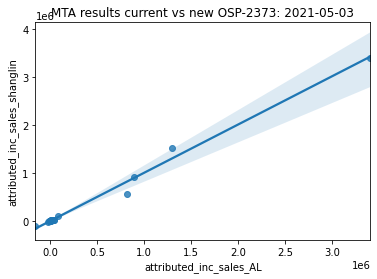

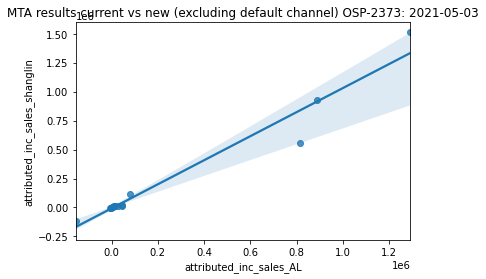

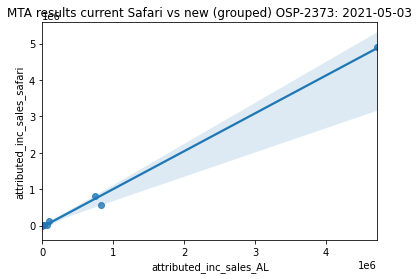

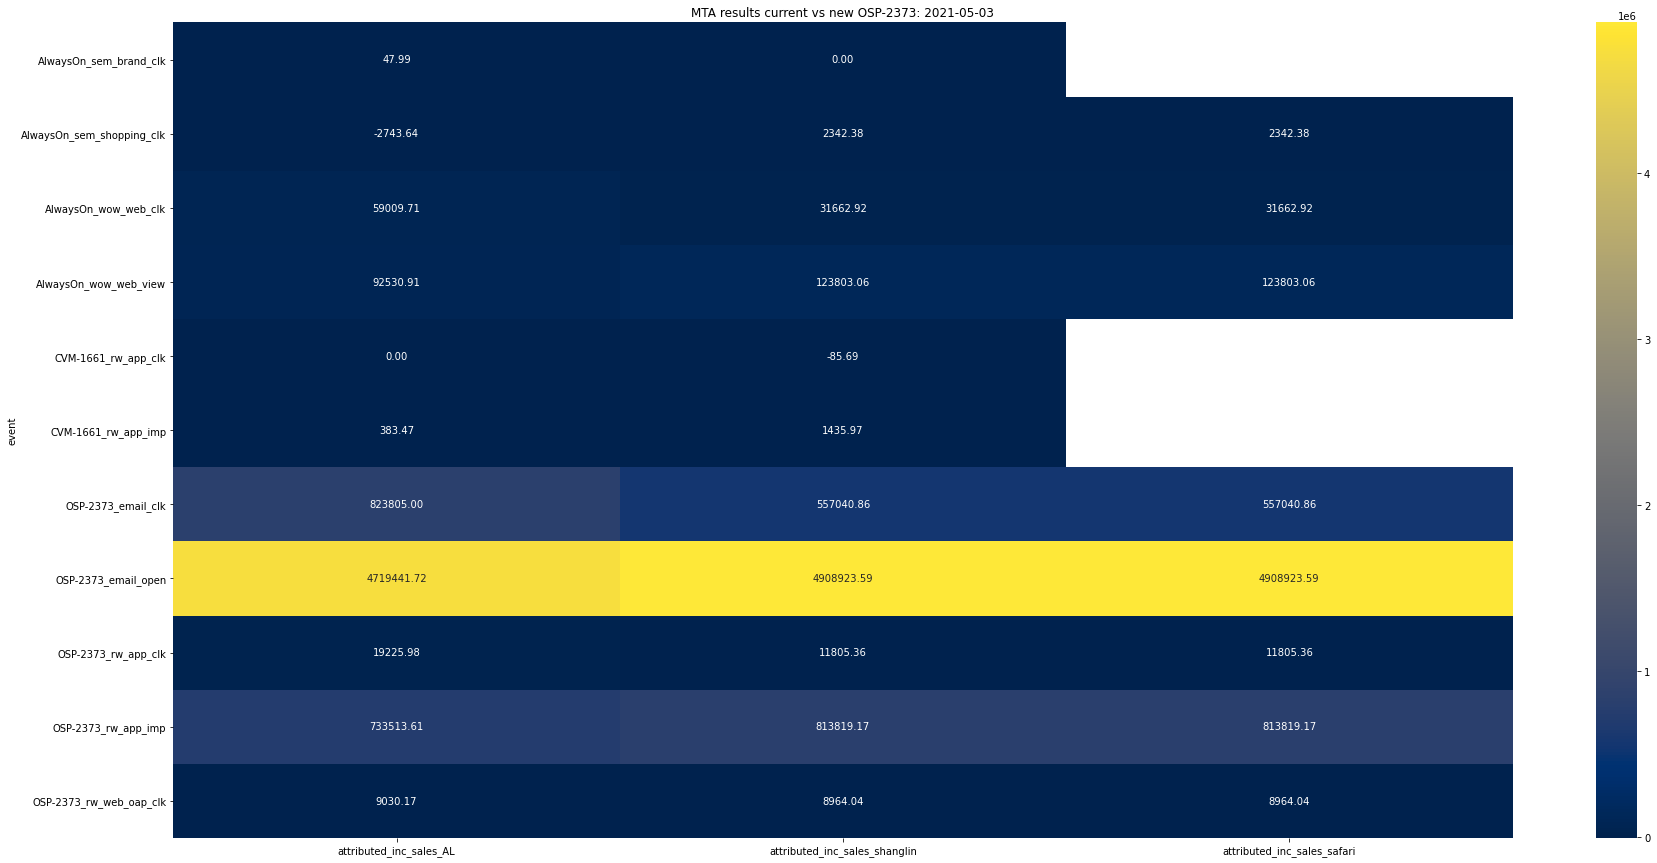

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000156                    0.000000   
AlwaysOn_sem_shopping_clk              0.000998                    0.012386   
AlwaysOn_wow_web_clk                   0.029206                    0.051573   
AlwaysOn_wow_web_view                  0.032439                    0.116879   
CVM-1661_rw_app_clk                    0.000000                    0.000757   
CVM-1661_rw_app_imp                    0.002030                    0.007662   
OSP-2373_email_clk                     0.326389                    0.488234   
OSP-2373_email_open                    0.278405                    0.776464   
OSP-2373_rw_app_clk                    0.054146                    0.067824   
OSP-2373_rw_app_imp                    0.272759                    0.463526   
OSP-2373_rw_web_oap_clk                0.003547                    0.014682   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                4.799196e+01   
AlwaysOn_sem_shopping_clk            -2.743643e+03   
AlwaysOn_wow_web_clk                  5.900971e+04   
AlwaysOn_wow_web_view                 9.253091e+04   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   3.834670e+02   
OSP-2373_email_clk                    8.238050e+05   
OSP-2373_email_open                   4.719442e+06   
OSP-2373_rw_app_clk                   1.922598e+04   
OSP-2373_rw_app_imp                   7.335136e+05   
OSP-2373_rw_web_oap_clk               9.030174e+03   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      0.000000e+00   
AlwaysOn_sem_shopping_clk                   2.342378e+03   
AlwaysOn_wow_web_clk                        3.166292e+04   
AlwaysOn_wow_web_view                       1.238031e+05   
CVM-1661_rw_app_clk                        -8.568539e+01   
CVM-1661_rw_app_imp                         1.435966e+03   
OSP-2373_email_clk                          5.570409e+05   
OSP-2373_email_open                         4.908924e+06   
OSP-2373_rw_app_clk                         1.180536e+04   
OSP-2373_rw_app_imp                         8.138192e+05   
OSP-2373_rw_web_oap_clk                     8.964036e+03   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                             NaN  
AlwaysOn_sem_shopping_clk                 2.342378e+03  
AlwaysOn_wow_web_clk                      3.166292e+04  
AlwaysOn_wow_web_view                     1.238031e+05  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_email_clk                        5.570409e+05  
OSP-2373_email_open                       4.908924e+06  
OSP-2373_rw_app_clk                       1.180536e+04  
OSP-2373_rw_app_imp                       8.138192e+05  
OSP-2373_rw_web_oap_clk                   8.964036e+03

In [76]:
run_downstream_process(fpath_results="01_results/res_weighted_OSP-2373_2021-05-03_2021-05-09_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-03",
                       safari_run_date="2021-05-11",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-03_OSP-2373`
>>> Step 3: Compare results to BAU run


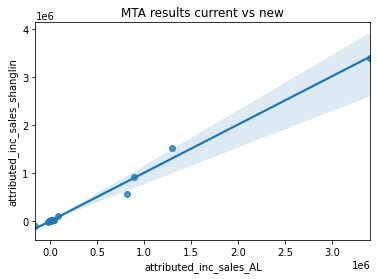

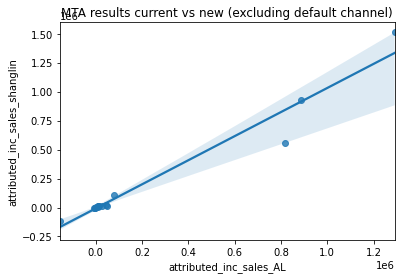

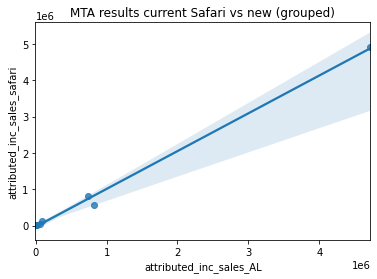

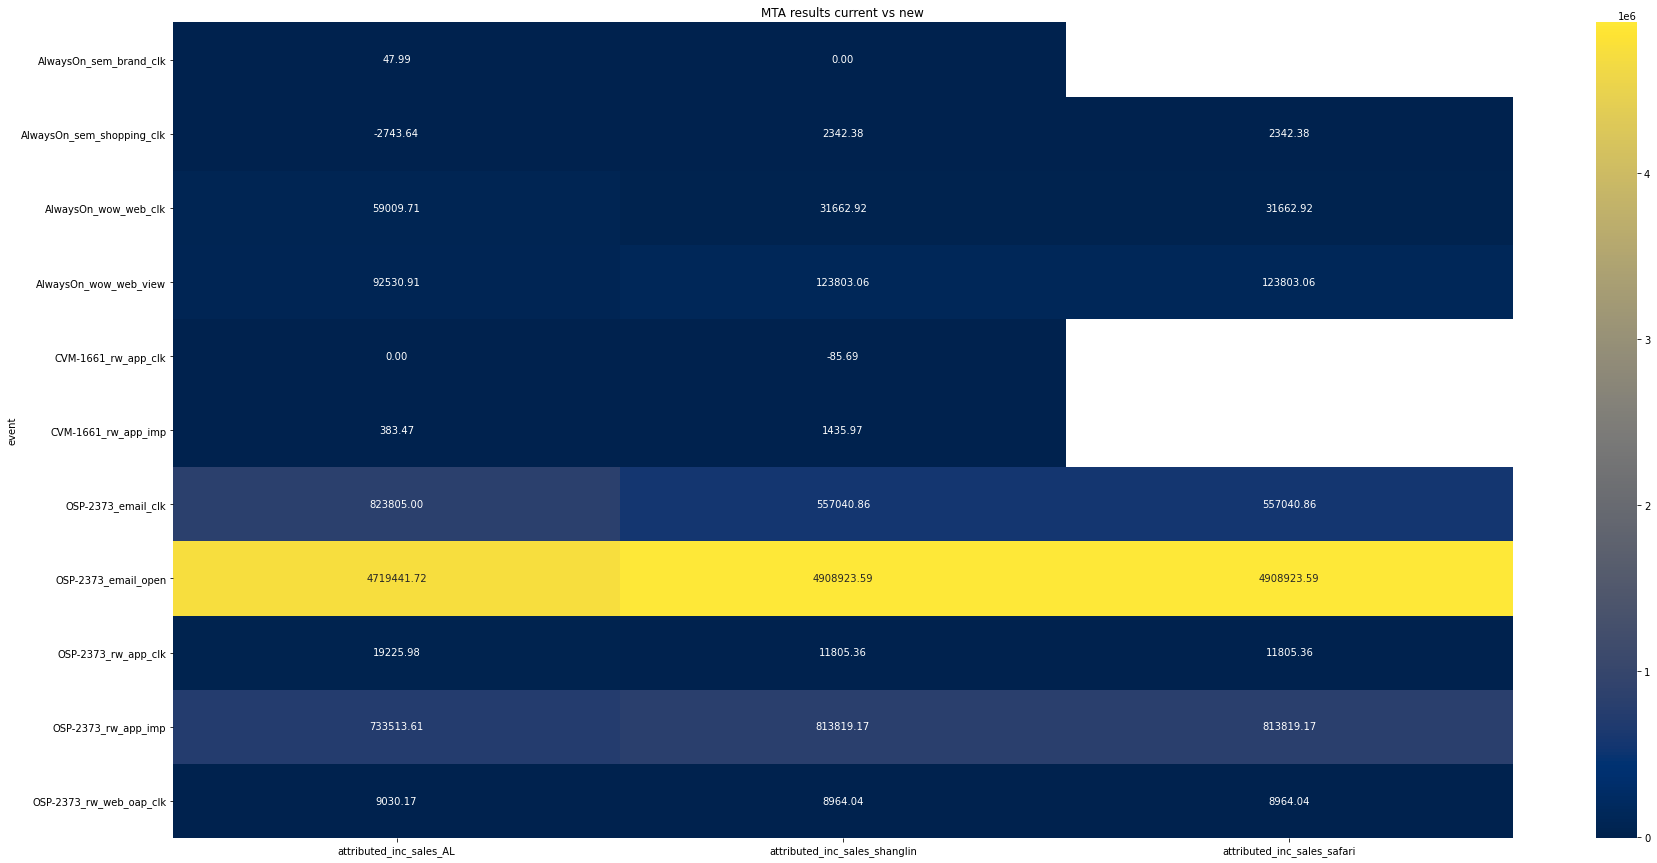

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000156                    0.000000   
AlwaysOn_sem_shopping_clk              0.000998                    0.012386   
AlwaysOn_wow_web_clk                   0.029206                    0.051573   
AlwaysOn_wow_web_view                  0.032439                    0.116879   
CVM-1661_rw_app_clk                    0.000000                    0.000757   
CVM-1661_rw_app_imp                    0.002030                    0.007662   
OSP-2373_email_clk                     0.326389                    0.488234   
OSP-2373_email_open                    0.278405                    0.776464   
OSP-2373_rw_app_clk                    0.054146                    0.067824   
OSP-2373_rw_app_imp                    0.272759                    0.463526   
OSP-2373_rw_web_oap_clk                0.003547                    0.014682   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                4.799196e+01   
AlwaysOn_sem_shopping_clk            -2.743643e+03   
AlwaysOn_wow_web_clk                  5.900971e+04   
AlwaysOn_wow_web_view                 9.253091e+04   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   3.834670e+02   
OSP-2373_email_clk                    8.238050e+05   
OSP-2373_email_open                   4.719442e+06   
OSP-2373_rw_app_clk                   1.922598e+04   
OSP-2373_rw_app_imp                   7.335136e+05   
OSP-2373_rw_web_oap_clk               9.030174e+03   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      0.000000e+00   
AlwaysOn_sem_shopping_clk                   2.342378e+03   
AlwaysOn_wow_web_clk                        3.166292e+04   
AlwaysOn_wow_web_view                       1.238031e+05   
CVM-1661_rw_app_clk                        -8.568539e+01   
CVM-1661_rw_app_imp                         1.435966e+03   
OSP-2373_email_clk                          5.570409e+05   
OSP-2373_email_open                         4.908924e+06   
OSP-2373_rw_app_clk                         1.180536e+04   
OSP-2373_rw_app_imp                         8.138192e+05   
OSP-2373_rw_web_oap_clk                     8.964036e+03   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                             NaN  
AlwaysOn_sem_shopping_clk                 2.342378e+03  
AlwaysOn_wow_web_clk                      3.166292e+04  
AlwaysOn_wow_web_view                     1.238031e+05  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_email_clk                        5.570409e+05  
OSP-2373_email_open                       4.908924e+06  
OSP-2373_rw_app_clk                       1.180536e+04  
OSP-2373_rw_app_imp                       8.138192e+05  
OSP-2373_rw_web_oap_clk                   8.964036e+03

In [41]:
run_downstream_process(fpath_results="01_results/res_weighted_OSP-2373_2021-05-03_2021-05-09_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-03",
                       safari_run_date="2021-05-11",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=False,
                       fpath_comparison_results="02_comparison/res_weighted")

# With FB

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-10_OSP-2373`
>>> Step 3: Compare results to BAU run


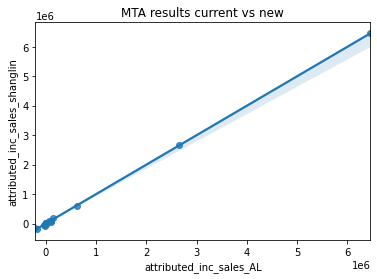

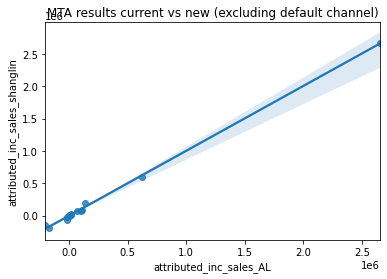

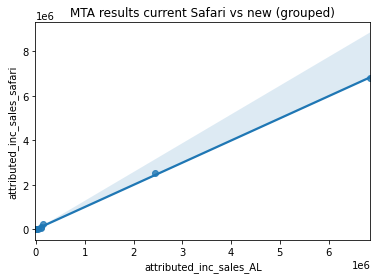

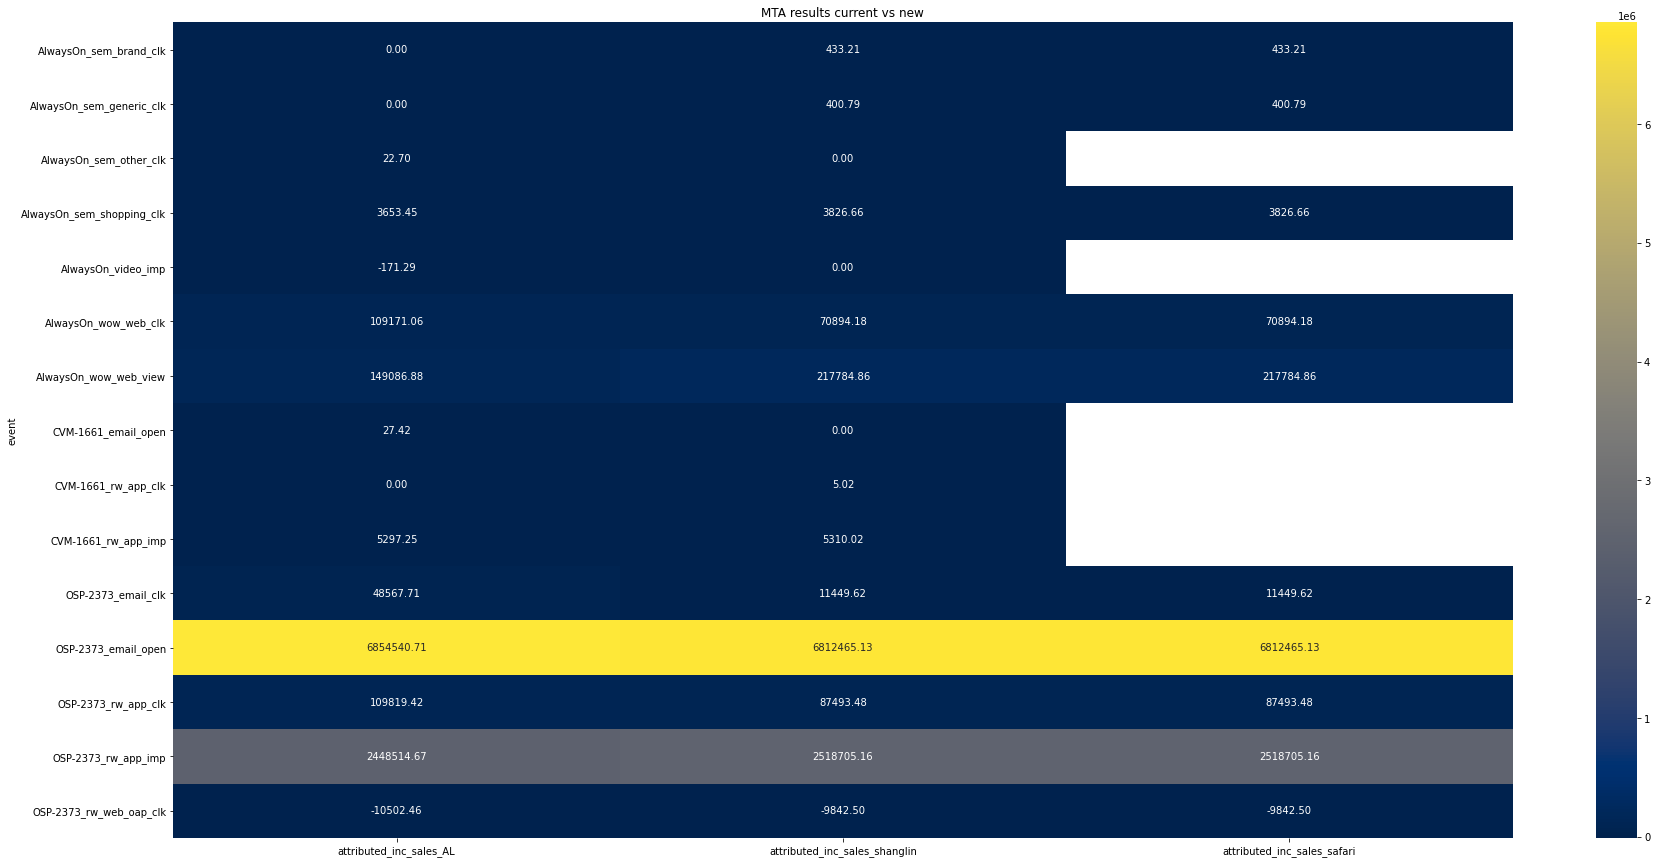

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-05-10 ... end of fw is 2021-05-16
	FB scaling ratio is (for missing slice of pie) 0.0868665067767141
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.08686650677817585
	touchpoint count increased by 417420
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-10_OSP-2373`


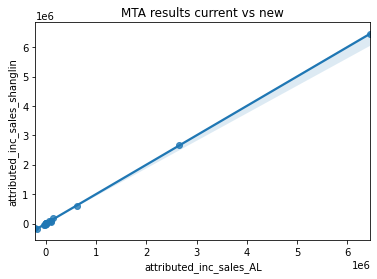

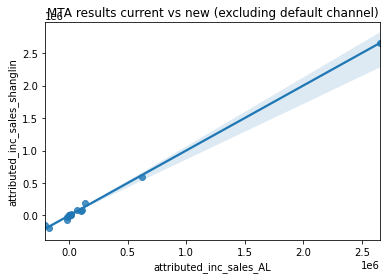

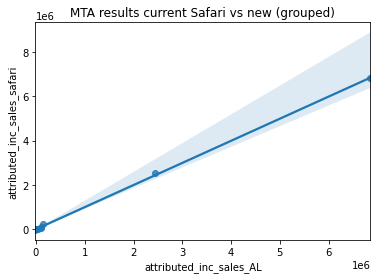

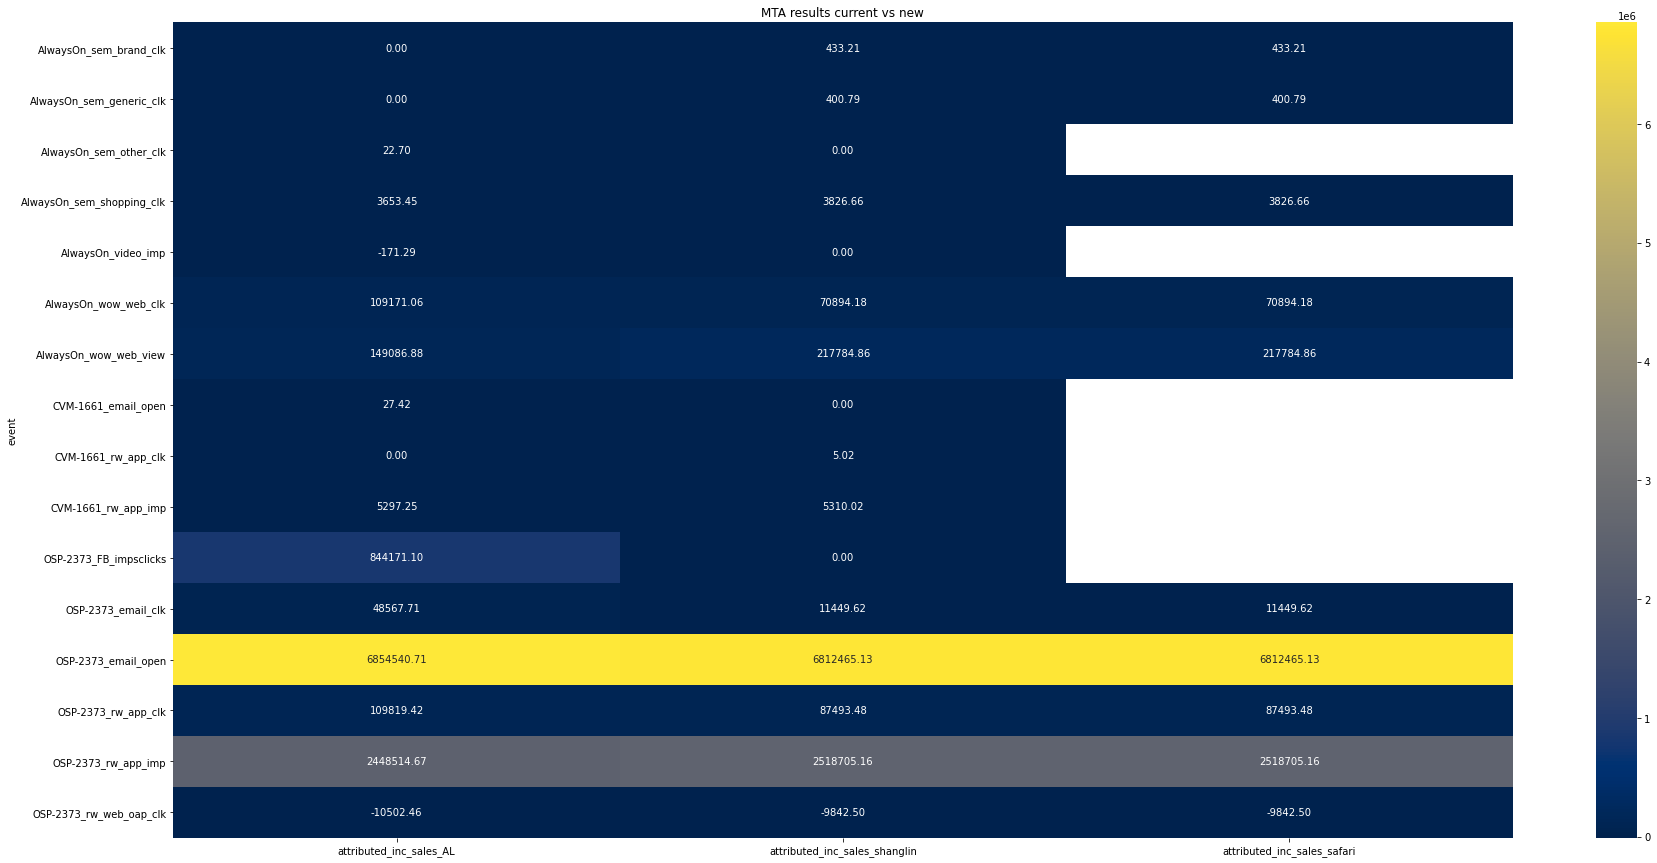

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000000                    0.002866   
AlwaysOn_sem_generic_clk               0.000000                    0.001657   
AlwaysOn_sem_other_clk                 0.001154                    0.000000   
AlwaysOn_sem_shopping_clk              0.005888                    0.027606   
AlwaysOn_video_imp                     0.000003                    0.000000   
AlwaysOn_wow_web_clk                   0.060102                    0.136680   
AlwaysOn_wow_web_view                  0.064757                    0.262769   
CVM-1661_email_open                    0.000488                    0.000000   
CVM-1661_rw_app_clk                    0.000000                    0.000968   
CVM-1661_rw_app_imp                    0.003076                    0.005648   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.042614                    0.309087   
OSP-2373_email_open                    0.110322                    0.496630   
OSP-2373_rw_app_clk                    0.120321                    0.131773   
OSP-2373_rw_app_imp                    0.589610                    0.605252   
OSP-2373_rw_web_oap_clk                0.001665                    0.019050   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                0.000000e+00   
AlwaysOn_sem_generic_clk              0.000000e+00   
AlwaysOn_sem_other_clk                2.269932e+01   
AlwaysOn_sem_shopping_clk             3.653445e+03   
AlwaysOn_video_imp                   -1.712945e+02   
AlwaysOn_wow_web_clk                  1.091711e+05   
AlwaysOn_wow_web_view                 1.490869e+05   
CVM-1661_email_open                   2.741992e+01   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   5.297252e+03   
OSP-2373_FB_impsclicks                8.441711e+05   
OSP-2373_email_clk                    4.856771e+04   
OSP-2373_email_open                   6.854541e+06   
OSP-2373_rw_app_clk                   1.098194e+05   
OSP-2373_rw_app_imp                   2.448515e+06   
OSP-2373_rw_web_oap_clk              -1.050246e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      4.332057e+02   
AlwaysOn_sem_generic_clk                    4.007940e+02   
AlwaysOn_sem_other_clk                      0.000000e+00   
AlwaysOn_sem_shopping_clk                   3.826662e+03   
AlwaysOn_video_imp                          0.000000e+00   
AlwaysOn_wow_web_clk                        7.089418e+04   
AlwaysOn_wow_web_view                       2.177849e+05   
CVM-1661_email_open                         0.000000e+00   
CVM-1661_rw_app_clk                         5.022599e+00   
CVM-1661_rw_app_imp                         5.310020e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          1.144962e+04   
OSP-2373_email_open                         6.812465e+06   
OSP-2373_rw_app_clk                         8.749348e+04   
OSP-2373_rw_app_imp                         2.518705e+06   
OSP-2373_rw_web_oap_clk                    -9.842502e+03   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    4.332057e+02  
AlwaysOn_sem_generic_clk                  4.007940e+02  
AlwaysOn_sem_other_clk                             NaN  
AlwaysOn_sem_shopping_clk                 3.826662e+03  
AlwaysOn_video_imp                                 NaN  
AlwaysOn_wow_web_clk                      7.089418e+04  
AlwaysOn_wow_web_view                     2.177849e+05  
CVM-1661_email_open                  

In [72]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-05-10_2021-05-16_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-10",
                       safari_run_date="2021-05-18",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-05-03_OSP-2373`
>>> Step 3: Compare results to BAU run


>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-05-03 ... end of fw is 2021-05-09
	FB scaling ratio is (for missing slice of pie) 0.05398394989361324
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.0539839498941756
	touchpoint count increased by 405543
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-05-03_OSP-2373`


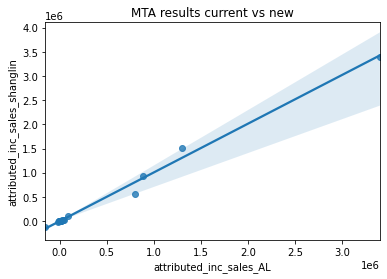

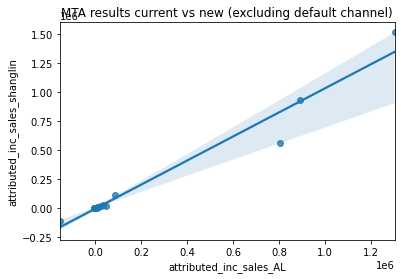

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_display_imp                   0.000366                    0.000000   
AlwaysOn_sem_shopping_clk              0.001155                    0.012386   
AlwaysOn_video_imp                     0.000113                    0.000000   
AlwaysOn_wow_web_clk                   0.024737                    0.051573   
AlwaysOn_wow_web_view                  0.033319                    0.116879   
CVM-1661_rw_app_clk                    0.000000                    0.000757   
CVM-1661_rw_app_imp                    0.000628                    0.007662   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.322077                    0.488234   
OSP-2373_email_open                    0.288385                    0.776464   
OSP-2373_rw_app_clk                    0.054566                    0.067824   
OSP-2373_rw_app_imp                    0.271311                    0.463526   
OSP-2373_rw_web_oap_clk                0.003549                    0.014682   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_display_imp                 -2.863241e+02   
AlwaysOn_sem_shopping_clk            -2.746815e+03   
AlwaysOn_video_imp                    4.016643e+01   
AlwaysOn_wow_web_clk                  4.972735e+04   
AlwaysOn_wow_web_view                 9.978576e+04   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   3.499159e+02   
OSP-2373_FB_impsclicks                3.484101e+05   
OSP-2373_email_clk                    8.112894e+05   
OSP-2373_email_open                   4.729792e+06   
OSP-2373_rw_app_clk                   1.909350e+04   
OSP-2373_rw_app_imp                   7.377130e+05   
OSP-2373_rw_web_oap_clk               9.198646e+03   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_display_imp                        0.000000e+00   
AlwaysOn_sem_shopping_clk                   2.342378e+03   
AlwaysOn_video_imp                          0.000000e+00   
AlwaysOn_wow_web_clk                        3.166292e+04   
AlwaysOn_wow_web_view                       1.238031e+05   
CVM-1661_rw_app_clk                        -8.568539e+01   
CVM-1661_rw_app_imp                         1.435966e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          5.570409e+05   
OSP-2373_email_open                         4.908924e+06   
OSP-2373_rw_app_clk                         1.180536e+04   
OSP-2373_rw_app_imp                         8.138192e+05   
OSP-2373_rw_web_oap_clk                     8.964036e+03   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_display_imp                               NaN  
AlwaysOn_sem_shopping_clk                 2.342378e+03  
AlwaysOn_video_imp                                 NaN  
AlwaysOn_wow_web_clk                      3.166292e+04  
AlwaysOn_wow_web_view                     1.238031e+05  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        5.570409e+05  
OSP-2373_email_open                       4.908924e+06  
OSP-2373_rw_app_clk                       1.180536e+04  
OSP-2373_rw_app_imp                       8.138192e+05  
OSP-2373_rw_web_oap_clk                   8.964036e+03

In [44]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-05-03_2021-05-09_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-05-03",
                       safari_run_date="2021-05-11",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-26_OSP-2373`
>>> Step 3: Compare results to BAU run


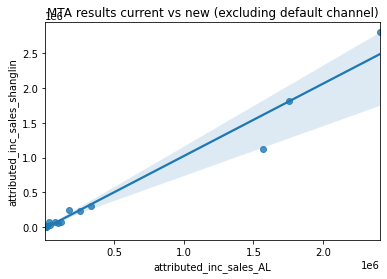

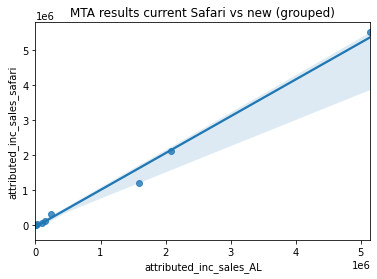

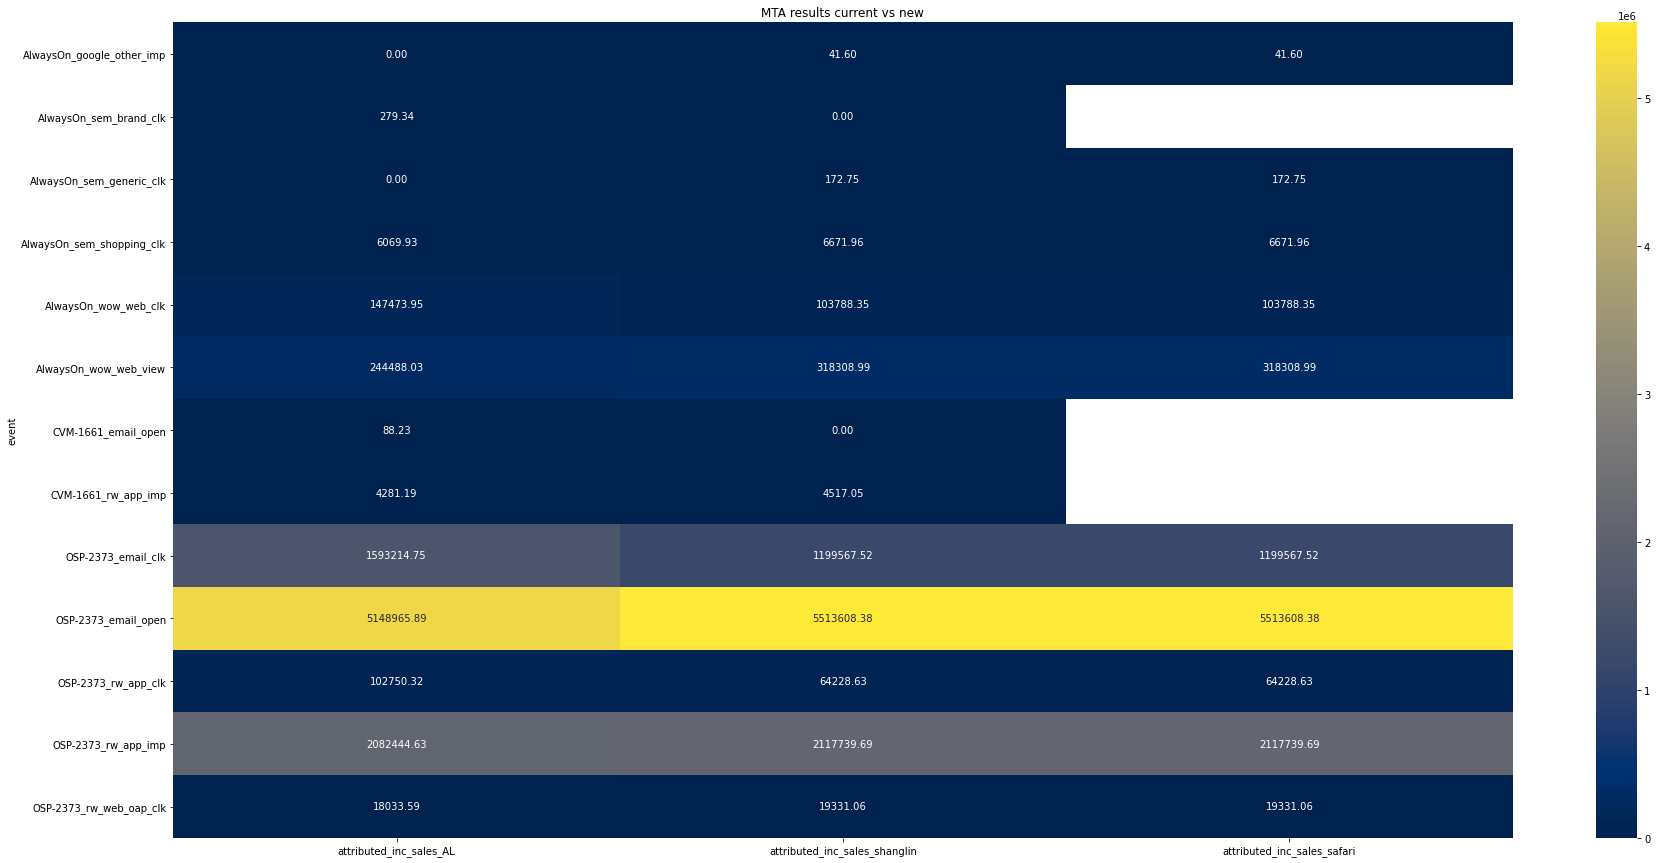

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-26 ... end of fw is 2021-05-02
	FB scaling ratio is (for missing slice of pie) 0.005626508940914705
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.005626508886426582
	touchpoint count increased by 417694
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-26_OSP-2373`


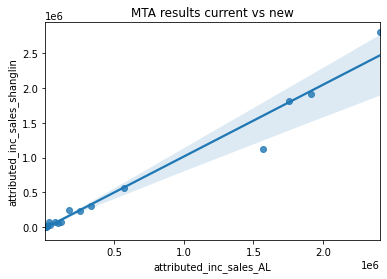

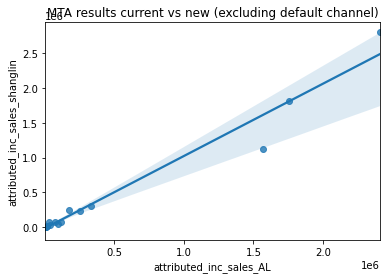

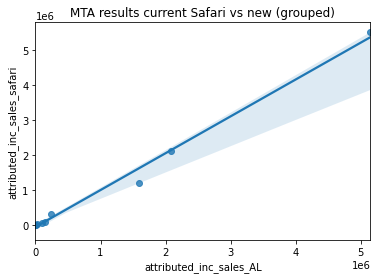

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000000                    0.001178   
AlwaysOn_sem_brand_clk                 0.000083                    0.000000   
AlwaysOn_sem_generic_clk               0.000000                    0.001056   
AlwaysOn_sem_shopping_clk              0.001340                    0.019191   
AlwaysOn_wow_web_clk                   0.026709                    0.084996   
AlwaysOn_wow_web_view                  0.027003                    0.151728   
CVM-1661_email_open                    0.000162                    0.000000   
CVM-1661_rw_app_imp                    0.004825                    0.013294   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.327369                    0.440363   
OSP-2373_email_open                    0.295113                    0.725882   
OSP-2373_rw_app_clk                    0.059015                    0.076657   
OSP-2373_rw_app_imp                    0.257054                    0.464335   
OSP-2373_rw_web_oap_clk                0.001327                    0.021304   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             0.000000e+00   
AlwaysOn_sem_brand_clk                2.793412e+02   
AlwaysOn_sem_generic_clk              0.000000e+00   
AlwaysOn_sem_shopping_clk             6.069929e+03   
AlwaysOn_wow_web_clk                  1.474739e+05   
AlwaysOn_wow_web_view                 2.444880e+05   
CVM-1661_email_open                   8.822706e+01   
CVM-1661_rw_app_imp                   4.281189e+03   
OSP-2373_FB_impsclicks                5.259711e+04   
OSP-2373_email_clk                    1.593215e+06   
OSP-2373_email_open                   5.148966e+06   
OSP-2373_rw_app_clk                   1.027503e+05   
OSP-2373_rw_app_imp                   2.082445e+06   
OSP-2373_rw_web_oap_clk               1.803359e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   4.160447e+01   
AlwaysOn_sem_brand_clk                      0.000000e+00   
AlwaysOn_sem_generic_clk                    1.727469e+02   
AlwaysOn_sem_shopping_clk                   6.671957e+03   
AlwaysOn_wow_web_clk                        1.037883e+05   
AlwaysOn_wow_web_view                       3.183090e+05   
CVM-1661_email_open                         0.000000e+00   
CVM-1661_rw_app_imp                         4.517051e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          1.199568e+06   
OSP-2373_email_open                         5.513608e+06   
OSP-2373_rw_app_clk                         6.422863e+04   
OSP-2373_rw_app_imp                         2.117740e+06   
OSP-2373_rw_web_oap_clk                     1.933106e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                 4.160447e+01  
AlwaysOn_sem_brand_clk                             NaN  
AlwaysOn_sem_generic_clk                  1.727469e+02  
AlwaysOn_sem_shopping_clk                 6.671957e+03  
AlwaysOn_wow_web_clk                      1.037883e+05  
AlwaysOn_wow_web_view                     3.183090e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        1.199568e+06  
OSP-2373_email_open                       5.513608e+06  
OSP-2373_rw_app_clk                       6.422863e+04  
OSP-2373_rw_app_imp                       2.117740e+06  
OSP-2373_rw_web_oap_clk                   1.933106e+04

In [46]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-04-26_2021-05-02_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-26",
                       safari_run_date="2021-05-04",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-19_OSP-2373`
>>> Step 3: Compare results to BAU run


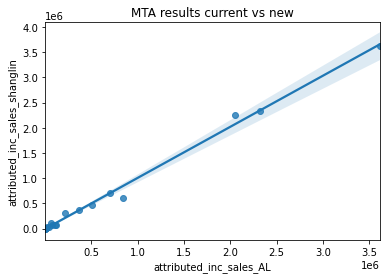

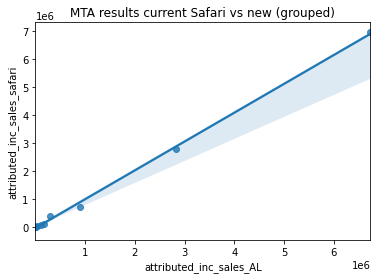

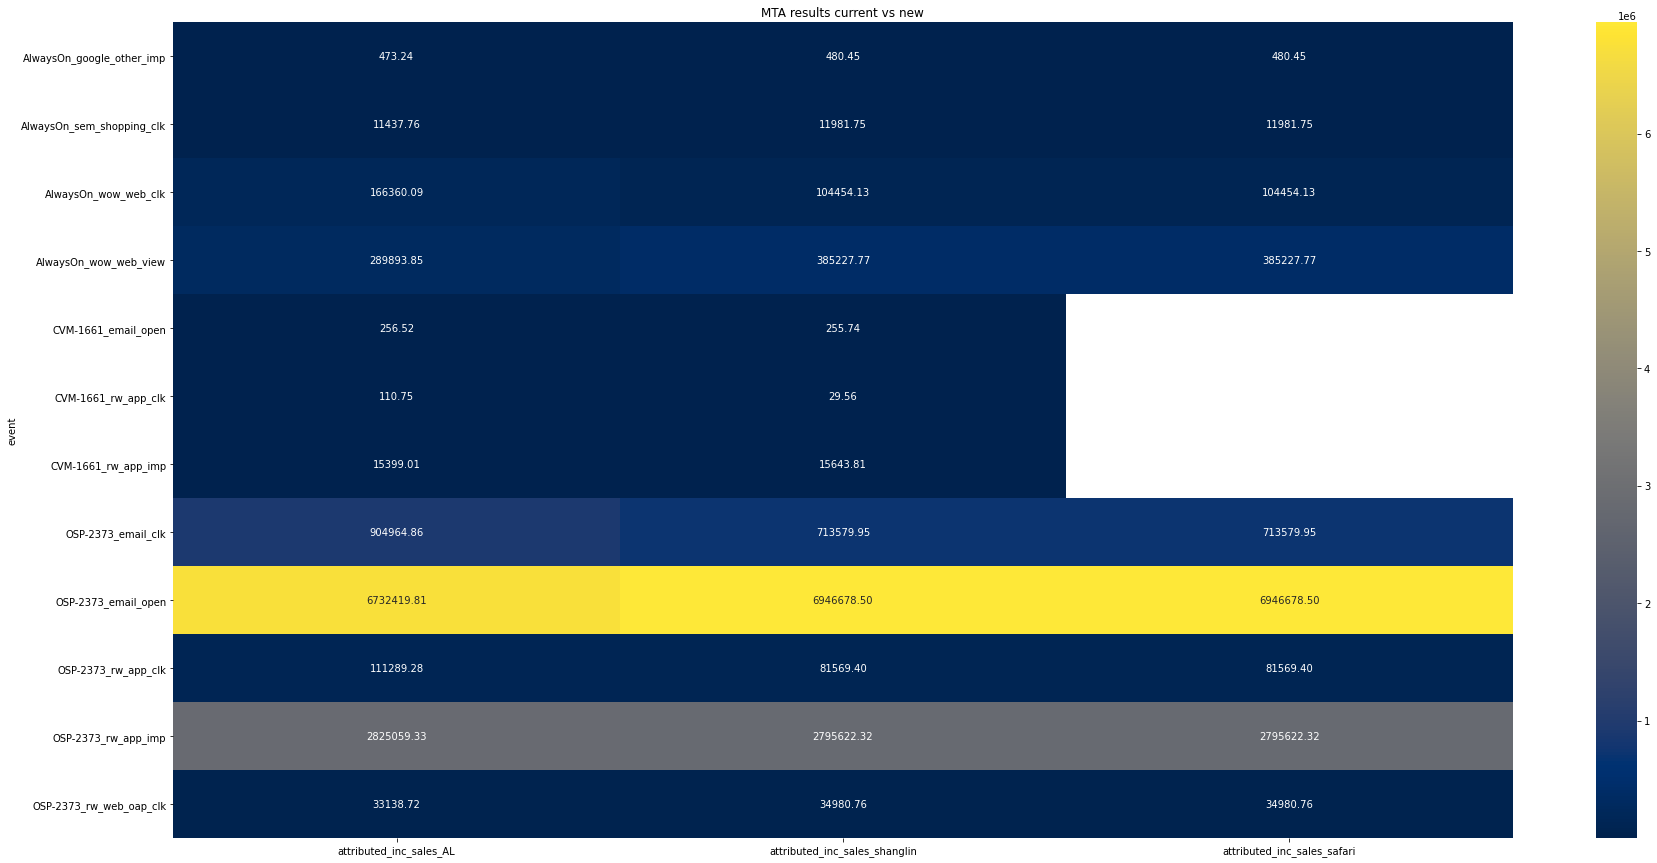

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-19 ... end of fw is 2021-04-25
	FB scaling ratio is (for missing slice of pie) 0.037429642205903044
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.03742964217594097
	touchpoint count increased by 384679
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-19_OSP-2373`


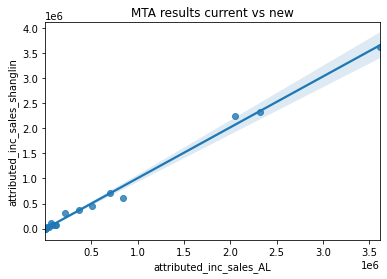

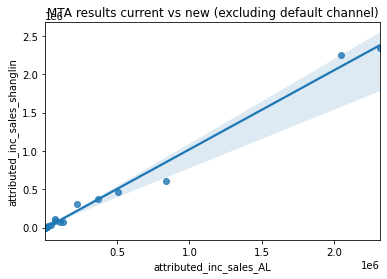

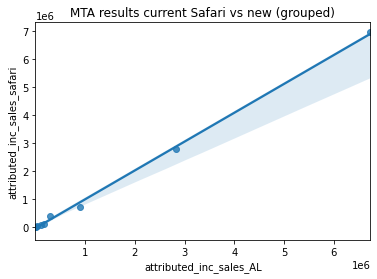

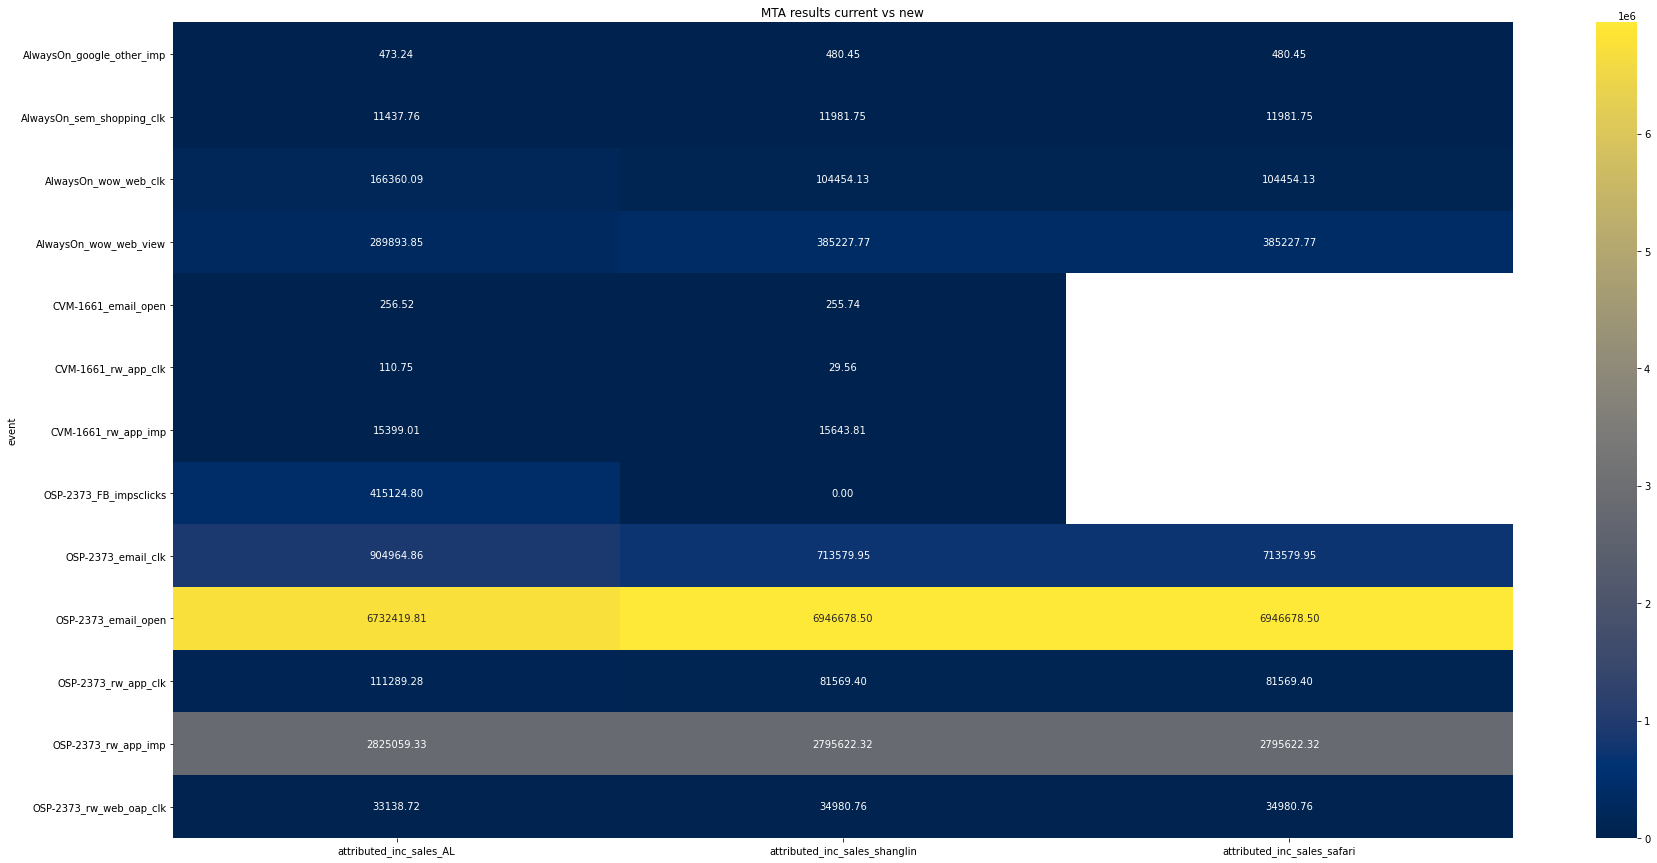

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000077                    0.001163   
AlwaysOn_sem_shopping_clk              0.003133                    0.014021   
AlwaysOn_wow_web_clk                   0.040506                    0.085955   
AlwaysOn_wow_web_view                  0.037715                    0.176636   
CVM-1661_email_open                    0.000312                    0.001181   
CVM-1661_rw_app_clk                    0.000017                    0.003874   
CVM-1661_rw_app_imp                    0.008745                    0.018404   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.228498                    0.374050   
OSP-2373_email_open                    0.265120                    0.696860   
OSP-2373_rw_app_clk                    0.073669                    0.080641   
OSP-2373_rw_app_imp                    0.337985                    0.507190   
OSP-2373_rw_web_oap_clk                0.004298                    0.040008   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             4.732440e+02   
AlwaysOn_sem_shopping_clk             1.143776e+04   
AlwaysOn_wow_web_clk                  1.663601e+05   
AlwaysOn_wow_web_view                 2.898938e+05   
CVM-1661_email_open                   2.565210e+02   
CVM-1661_rw_app_clk                   1.107491e+02   
CVM-1661_rw_app_imp                   1.539901e+04   
OSP-2373_FB_impsclicks                4.151248e+05   
OSP-2373_email_clk                    9.049649e+05   
OSP-2373_email_open                   6.732420e+06   
OSP-2373_rw_app_clk                   1.112893e+05   
OSP-2373_rw_app_imp                   2.825059e+06   
OSP-2373_rw_web_oap_clk               3.313872e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   4.804531e+02   
AlwaysOn_sem_shopping_clk                   1.198175e+04   
AlwaysOn_wow_web_clk                        1.044541e+05   
AlwaysOn_wow_web_view                       3.852278e+05   
CVM-1661_email_open                         2.557388e+02   
CVM-1661_rw_app_clk                         2.956202e+01   
CVM-1661_rw_app_imp                         1.564381e+04   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          7.135799e+05   
OSP-2373_email_open                         6.946679e+06   
OSP-2373_rw_app_clk                         8.156940e+04   
OSP-2373_rw_app_imp                         2.795622e+06   
OSP-2373_rw_web_oap_clk                     3.498076e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                 4.804531e+02  
AlwaysOn_sem_shopping_clk                 1.198175e+04  
AlwaysOn_wow_web_clk                      1.044541e+05  
AlwaysOn_wow_web_view                     3.852278e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        7.135799e+05  
OSP-2373_email_open                       6.946679e+06  
OSP-2373_rw_app_clk                       8.156940e+04  
OSP-2373_rw_app_imp                       2.795622e+06  
OSP-2373_rw_web_oap_clk                   3.498076e+04

In [47]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-04-19_2021-04-25_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-19",
                       safari_run_date="2021-04-27",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-12_OSP-2373`
>>> Step 3: Compare results to BAU run


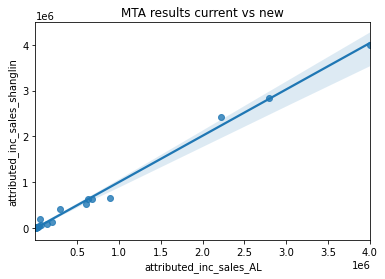

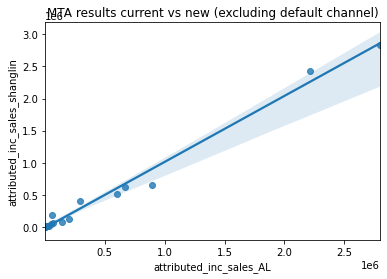

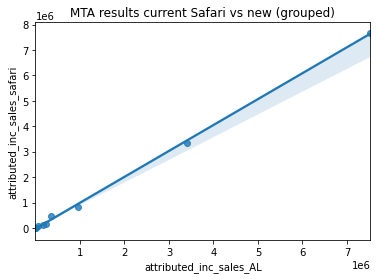

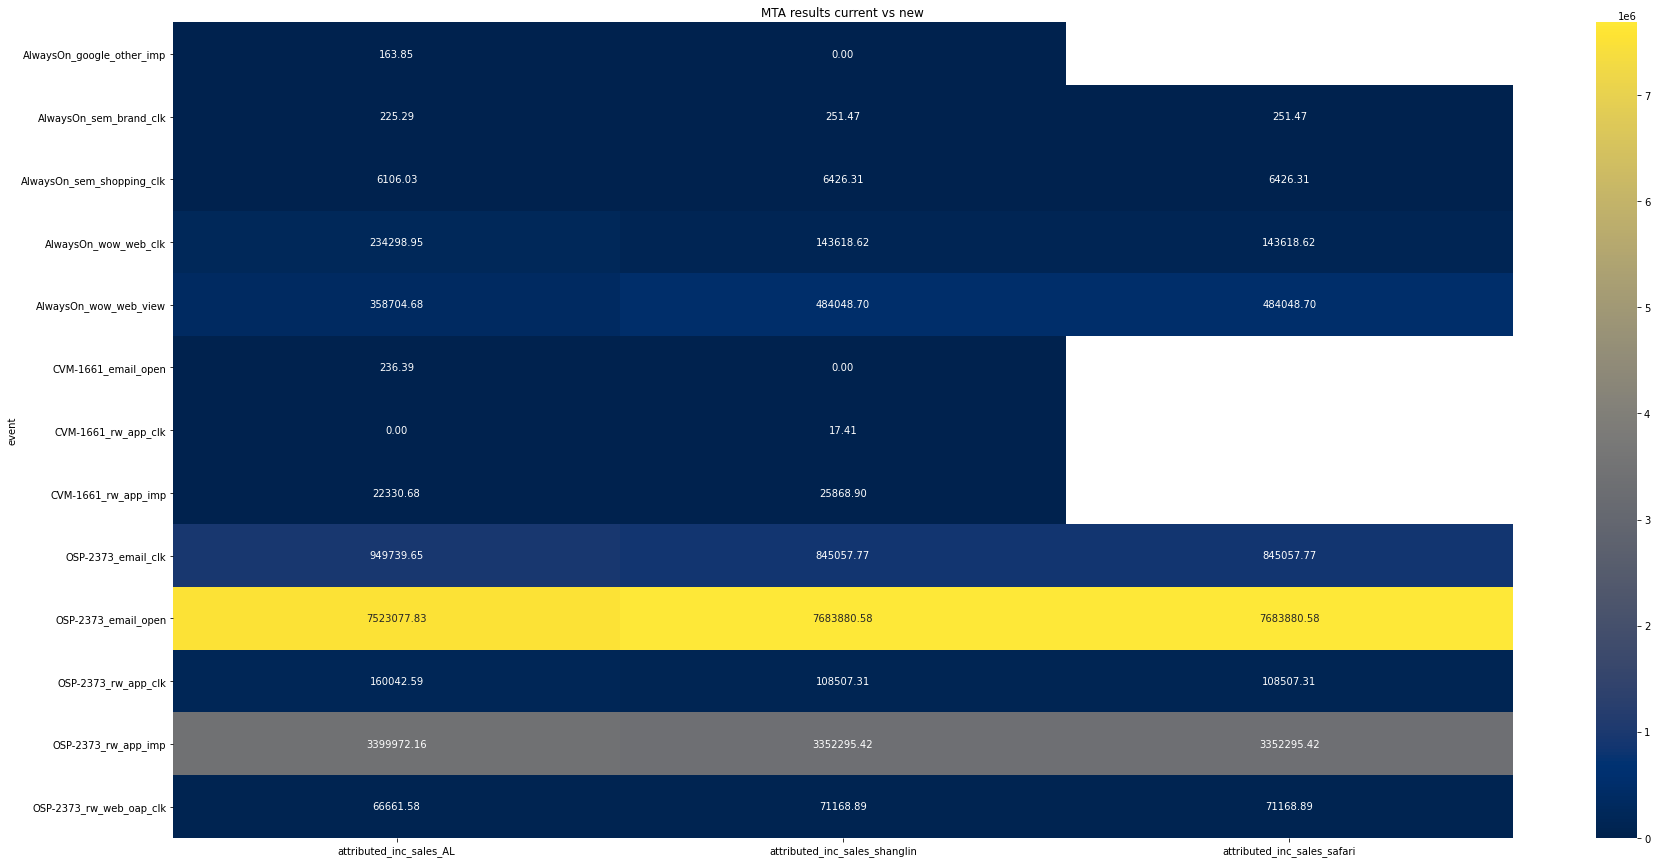

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-12 ... end of fw is 2021-04-18
	FB scaling ratio is (for missing slice of pie) 0.06552325628901332
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.06552325623193621
	touchpoint count increased by 408413
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-12_OSP-2373`


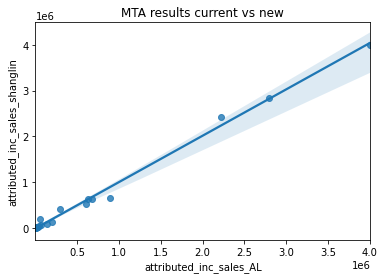

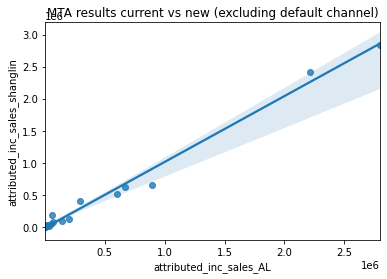

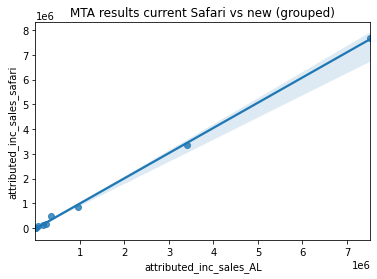

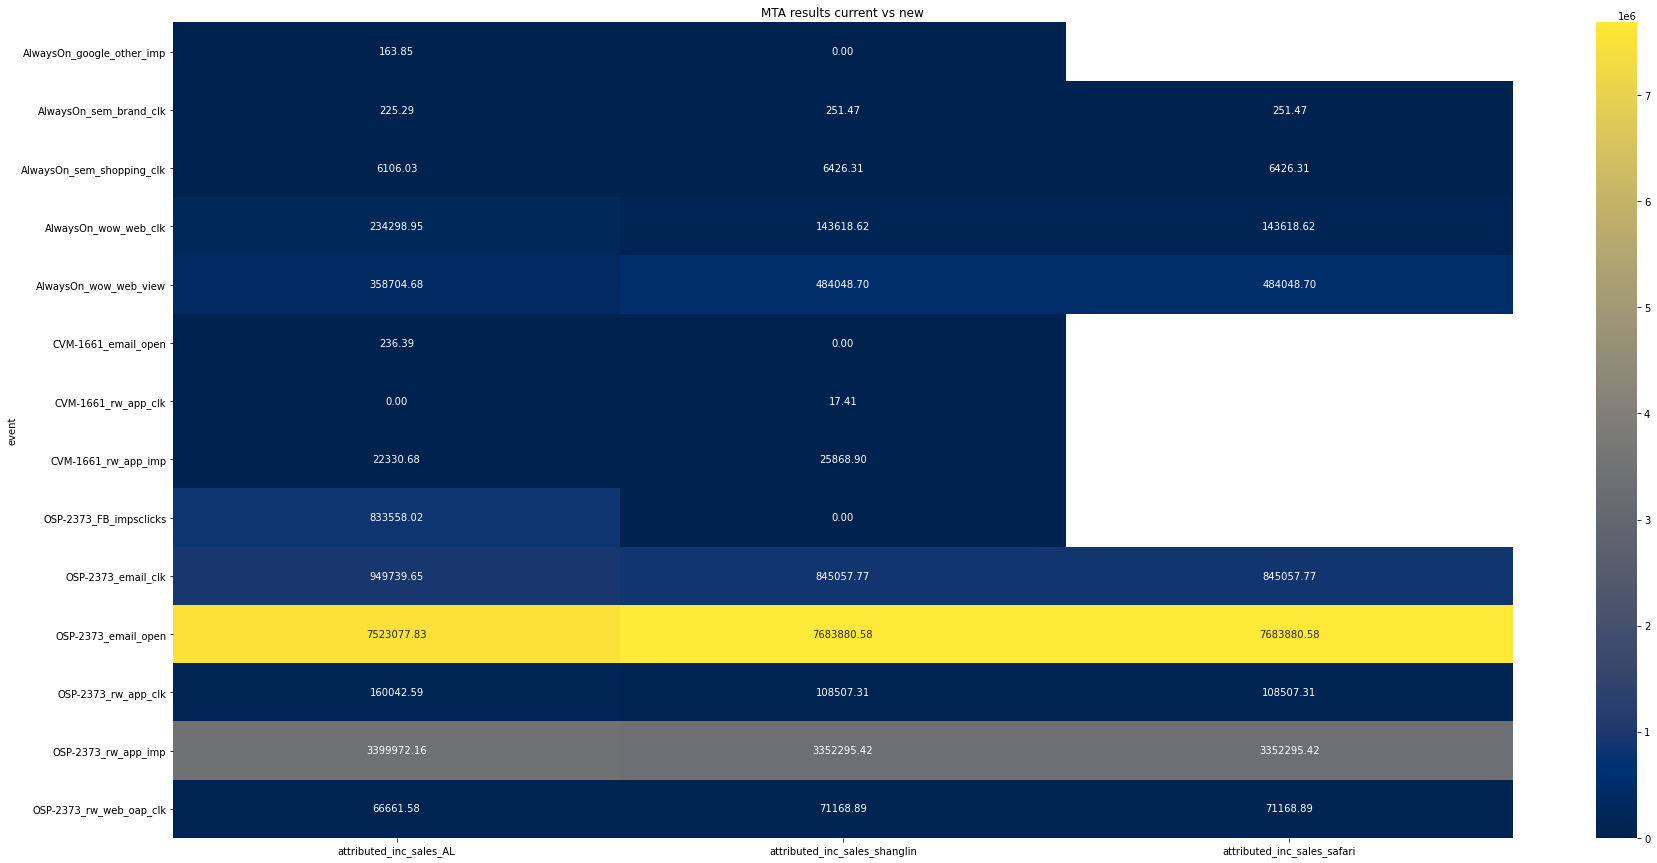

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000280                    0.000000   
AlwaysOn_sem_brand_clk                 0.000224                    0.001142   
AlwaysOn_sem_shopping_clk              0.001328                    0.007876   
AlwaysOn_wow_web_clk                   0.041615                    0.070791   
AlwaysOn_wow_web_view                  0.037225                    0.149902   
CVM-1661_email_open                    0.000206                    0.000000   
CVM-1661_rw_app_clk                    0.000000                    0.002358   
CVM-1661_rw_app_imp                    0.011528                    0.025717   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.214621                    0.417670   
OSP-2373_email_open                    0.255014                    0.745693   
OSP-2373_rw_app_clk                    0.074045                    0.072223   
OSP-2373_rw_app_imp                    0.357581                    0.460871   
OSP-2373_rw_web_oap_clk                0.006329                    0.045743   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             1.638465e+02   
AlwaysOn_sem_brand_clk                2.252895e+02   
AlwaysOn_sem_shopping_clk             6.106033e+03   
AlwaysOn_wow_web_clk                  2.342990e+05   
AlwaysOn_wow_web_view                 3.587047e+05   
CVM-1661_email_open                   2.363872e+02   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   2.233068e+04   
OSP-2373_FB_impsclicks                8.335580e+05   
OSP-2373_email_clk                    9.497396e+05   
OSP-2373_email_open                   7.523078e+06   
OSP-2373_rw_app_clk                   1.600426e+05   
OSP-2373_rw_app_imp                   3.399972e+06   
OSP-2373_rw_web_oap_clk               6.666158e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                   0.000000e+00   
AlwaysOn_sem_brand_clk                      2.514706e+02   
AlwaysOn_sem_shopping_clk                   6.426308e+03   
AlwaysOn_wow_web_clk                        1.436186e+05   
AlwaysOn_wow_web_view                       4.840487e+05   
CVM-1661_email_open                         0.000000e+00   
CVM-1661_rw_app_clk                         1.741215e+01   
CVM-1661_rw_app_imp                         2.586890e+04   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          8.450578e+05   
OSP-2373_email_open                         7.683881e+06   
OSP-2373_rw_app_clk                         1.085073e+05   
OSP-2373_rw_app_imp                         3.352295e+06   
OSP-2373_rw_web_oap_clk                     7.116889e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                          NaN  
AlwaysOn_sem_brand_clk                    2.514706e+02  
AlwaysOn_sem_shopping_clk                 6.426308e+03  
AlwaysOn_wow_web_clk                      1.436186e+05  
AlwaysOn_wow_web_view                     4.840487e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        8.450578e+05  
OSP-2373_email_open                       7.683881e+06  
OSP-2373_rw_app_clk                       1.085073e+05  
OSP-2373_rw_app_imp                       3.352295e+06  
OSP-2373_rw_web_oap_clk                   7.116889e+04

In [48]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-04-12_2021-04-18_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-12",
                       safari_run_date="2021-04-21",
                       create_dacamp_prod_mc_final=False,
                       have_historical_marketable_crn=True,                       
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-04-05_OSP-2373`
>>> Step 3: Compare results to BAU run


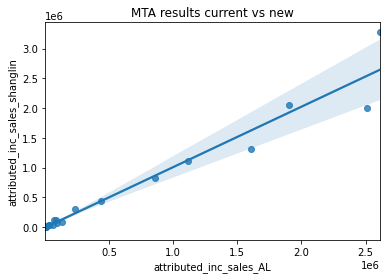

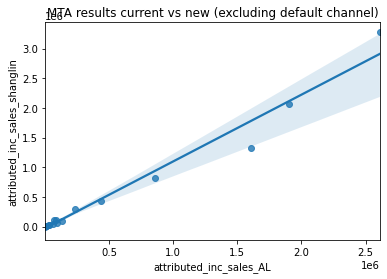

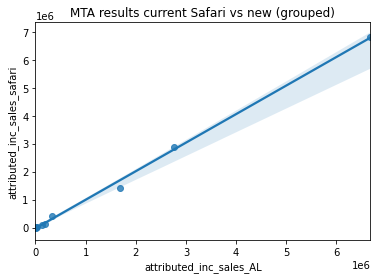

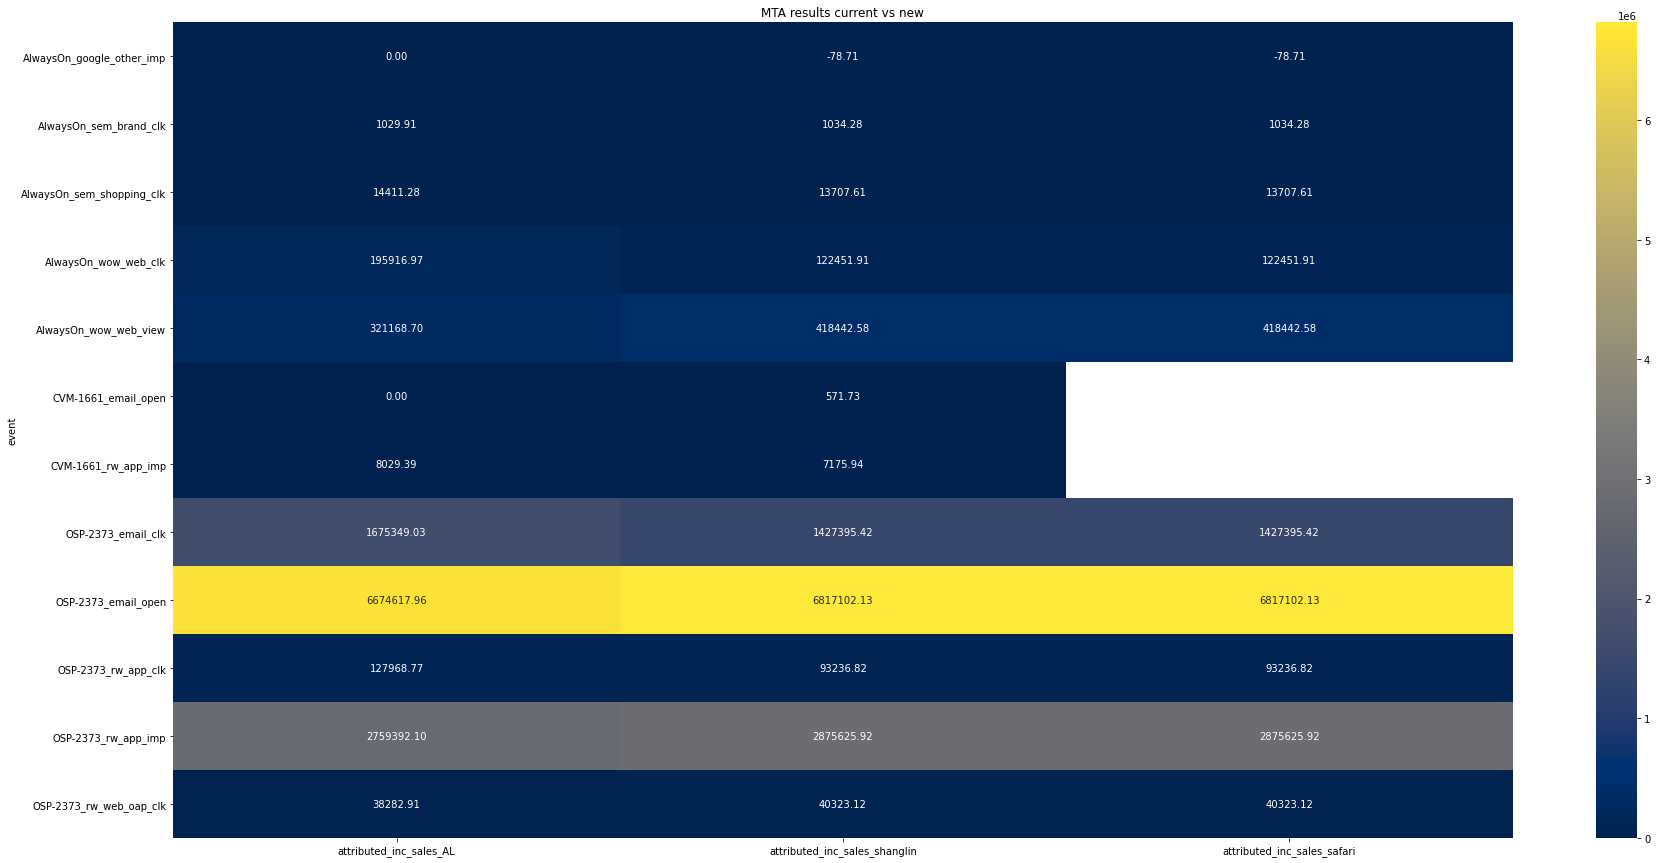

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-04-05 ... end of fw is 2021-04-11
	FB scaling ratio is (for missing slice of pie) 0.026905725792975253
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.026905725872153854
	touchpoint count increased by 391695
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-04-05_OSP-2373`


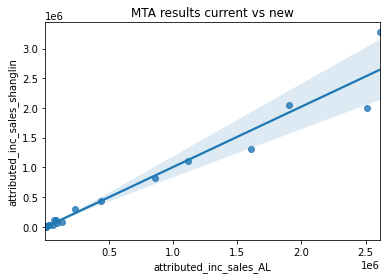

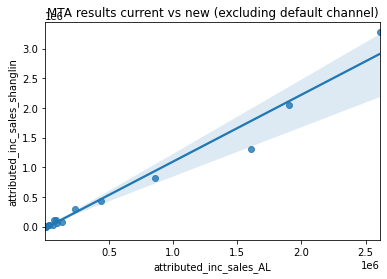

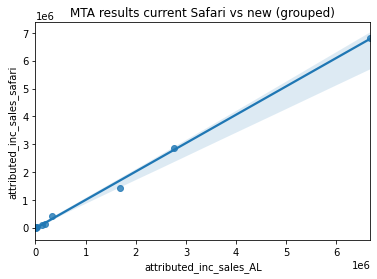

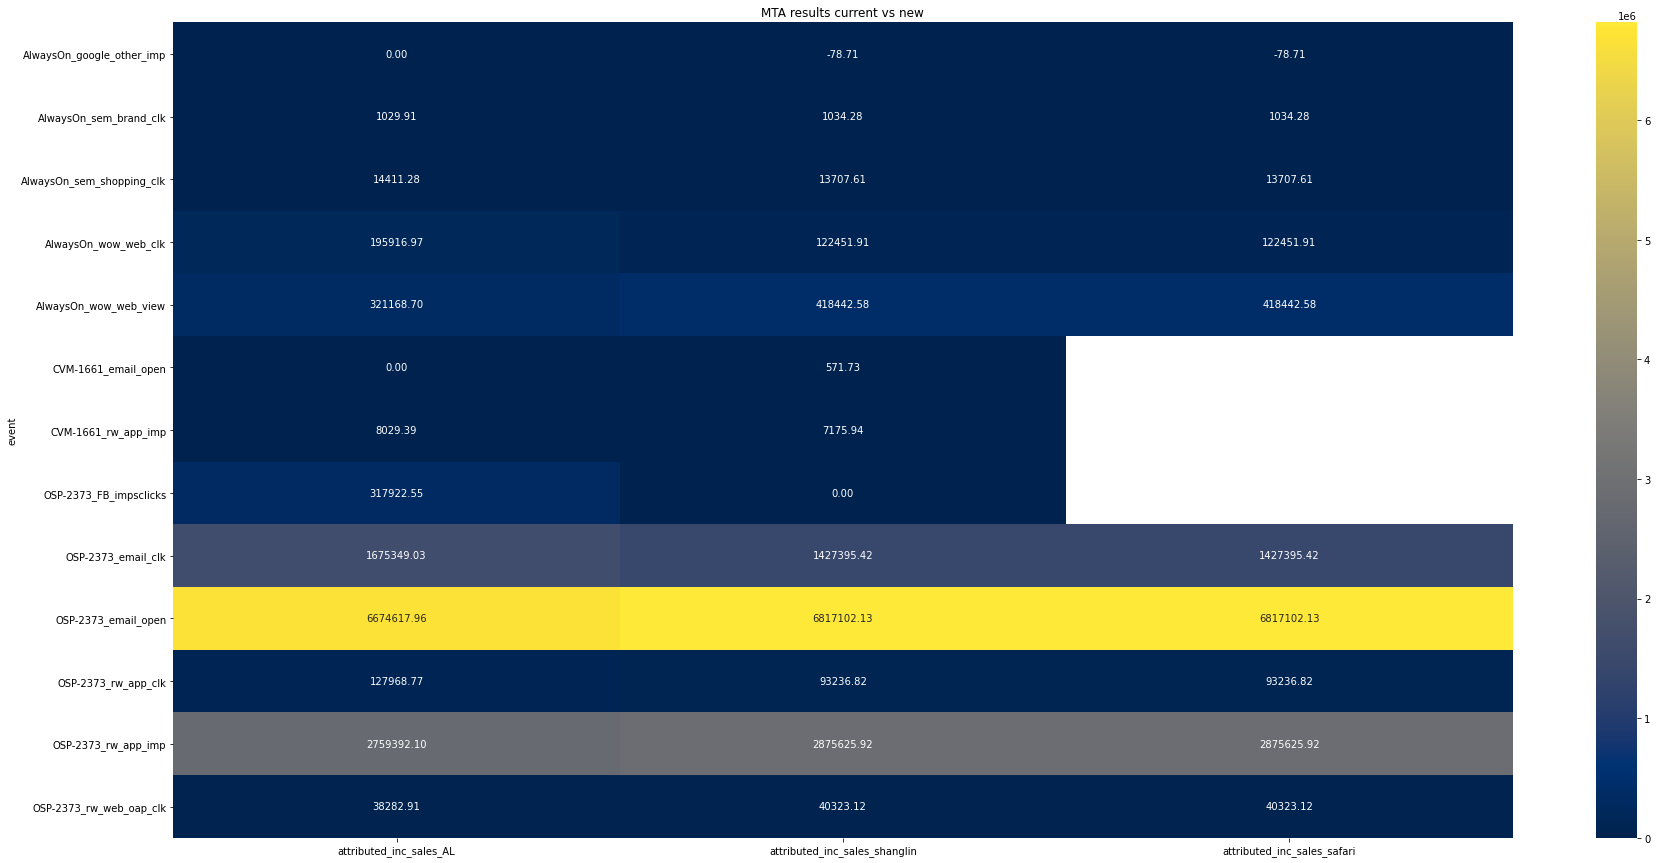

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000000                    0.001037   
AlwaysOn_sem_brand_clk                 0.000072                    0.002505   
AlwaysOn_sem_shopping_clk              0.002439                    0.010848   
AlwaysOn_wow_web_clk                   0.037325                    0.089561   
AlwaysOn_wow_web_view                  0.029721                    0.180016   
CVM-1661_email_open                    0.000000                    0.001252   
CVM-1661_rw_app_imp                    0.005083                    0.011670   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.309376                    0.390702   
OSP-2373_email_open                    0.290105                    0.681150   
OSP-2373_rw_app_clk                    0.058780                    0.074811   
OSP-2373_rw_app_imp                    0.263249                    0.501866   
OSP-2373_rw_web_oap_clk                0.004154                    0.054566   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp             0.000000e+00   
AlwaysOn_sem_brand_clk                1.029913e+03   
AlwaysOn_sem_shopping_clk             1.441128e+04   
AlwaysOn_wow_web_clk                  1.959170e+05   
AlwaysOn_wow_web_view                 3.211687e+05   
CVM-1661_email_open                   0.000000e+00   
CVM-1661_rw_app_imp                   8.029386e+03   
OSP-2373_FB_impsclicks                3.179225e+05   
OSP-2373_email_clk                    1.675349e+06   
OSP-2373_email_open                   6.674618e+06   
OSP-2373_rw_app_clk                   1.279688e+05   
OSP-2373_rw_app_imp                   2.759392e+06   
OSP-2373_rw_web_oap_clk               3.828291e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                  -7.870664e+01   
AlwaysOn_sem_brand_clk                      1.034276e+03   
AlwaysOn_sem_shopping_clk                   1.370761e+04   
AlwaysOn_wow_web_clk                        1.224519e+05   
AlwaysOn_wow_web_view                       4.184426e+05   
CVM-1661_email_open                         5.717261e+02   
CVM-1661_rw_app_imp                         7.175937e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          1.427395e+06   
OSP-2373_email_open                         6.817102e+06   
OSP-2373_rw_app_clk                         9.323682e+04   
OSP-2373_rw_app_imp                         2.875626e+06   
OSP-2373_rw_web_oap_clk                     4.032312e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                -7.870664e+01  
AlwaysOn_sem_brand_clk                    1.034276e+03  
AlwaysOn_sem_shopping_clk                 1.370761e+04  
AlwaysOn_wow_web_clk                      1.224519e+05  
AlwaysOn_wow_web_view                     4.184426e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        1.427395e+06  
OSP-2373_email_open                       6.817102e+06  
OSP-2373_rw_app_clk                       9.323682e+04  
OSP-2373_rw_app_imp                       2.875626e+06  
OSP-2373_rw_web_oap_clk                   4.032312e+04

In [62]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-04-05_2021-04-11_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-04-05",
                       safari_run_date="2021-04-13",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-29_OSP-2373`
>>> Step 3: Compare results to BAU run


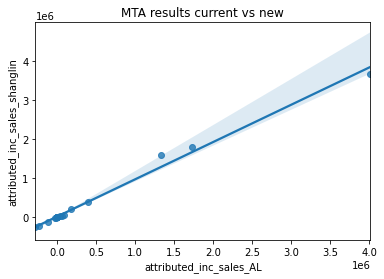

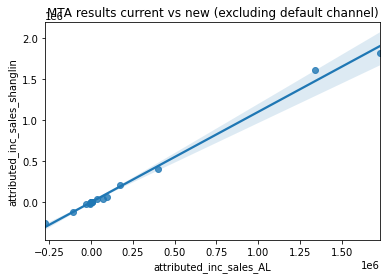

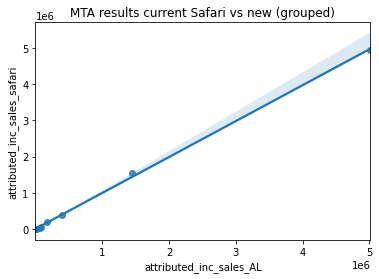

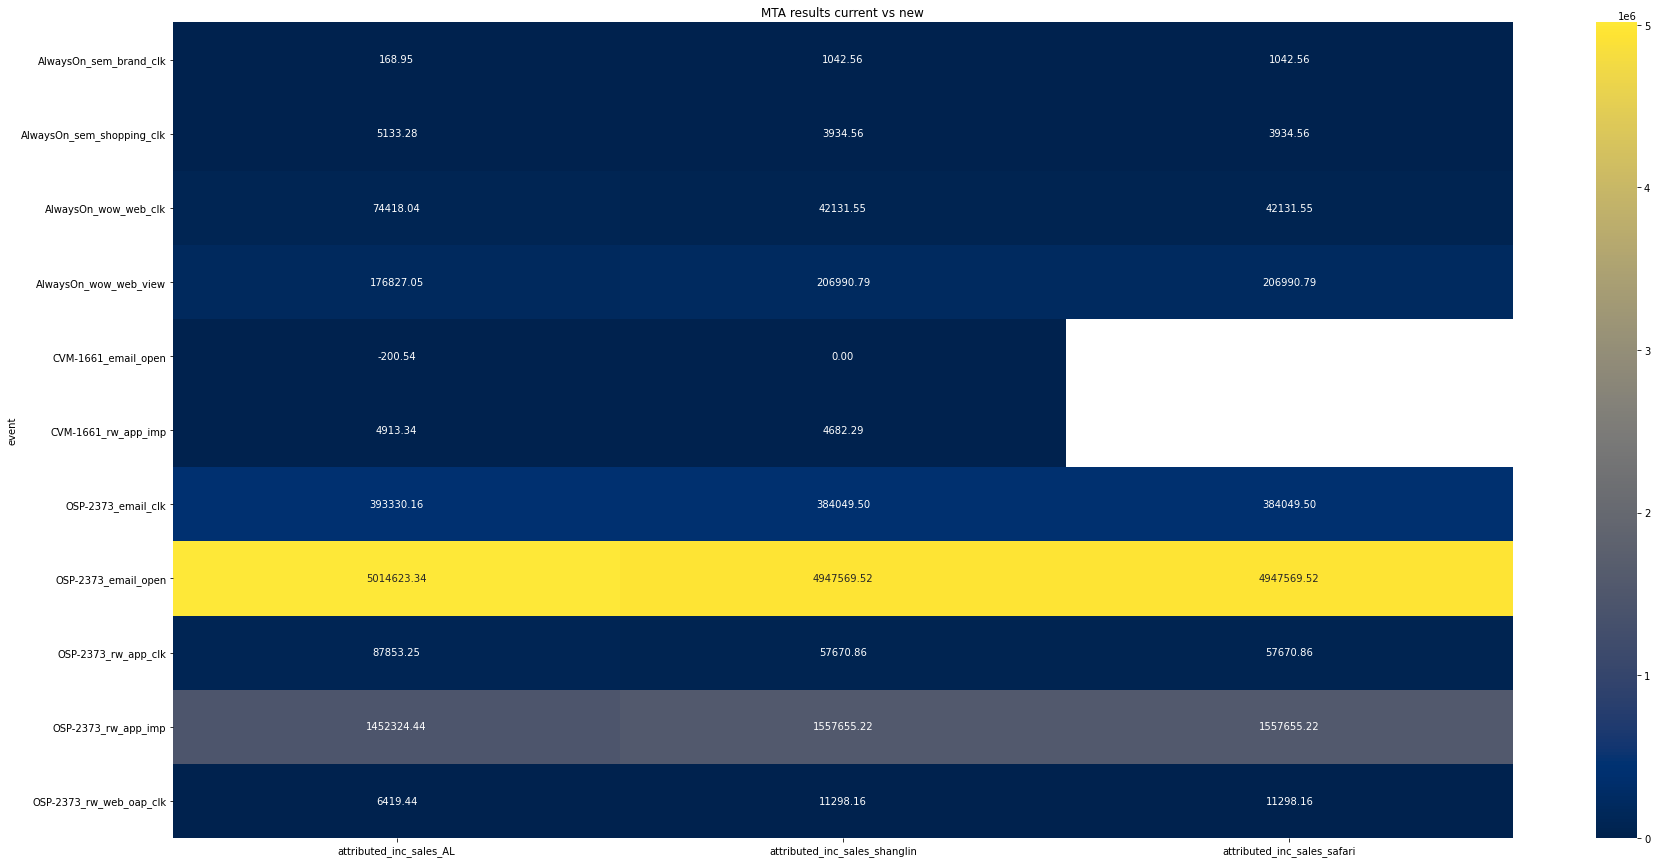

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-29 ... end of fw is 2021-04-04
	FB scaling ratio is (for missing slice of pie) 0.0835687295642125
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.08356872952930963
	touchpoint count increased by 452414
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-29_OSP-2373`


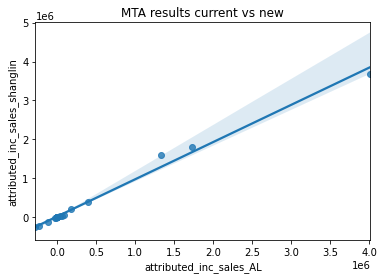

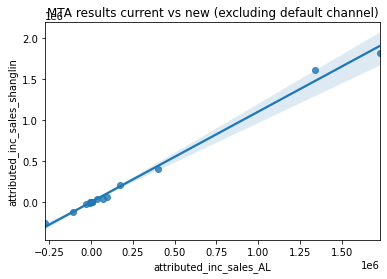

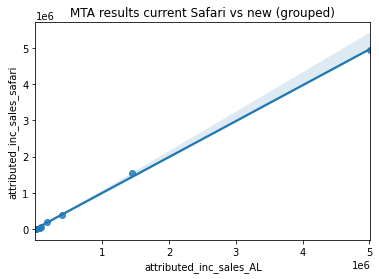

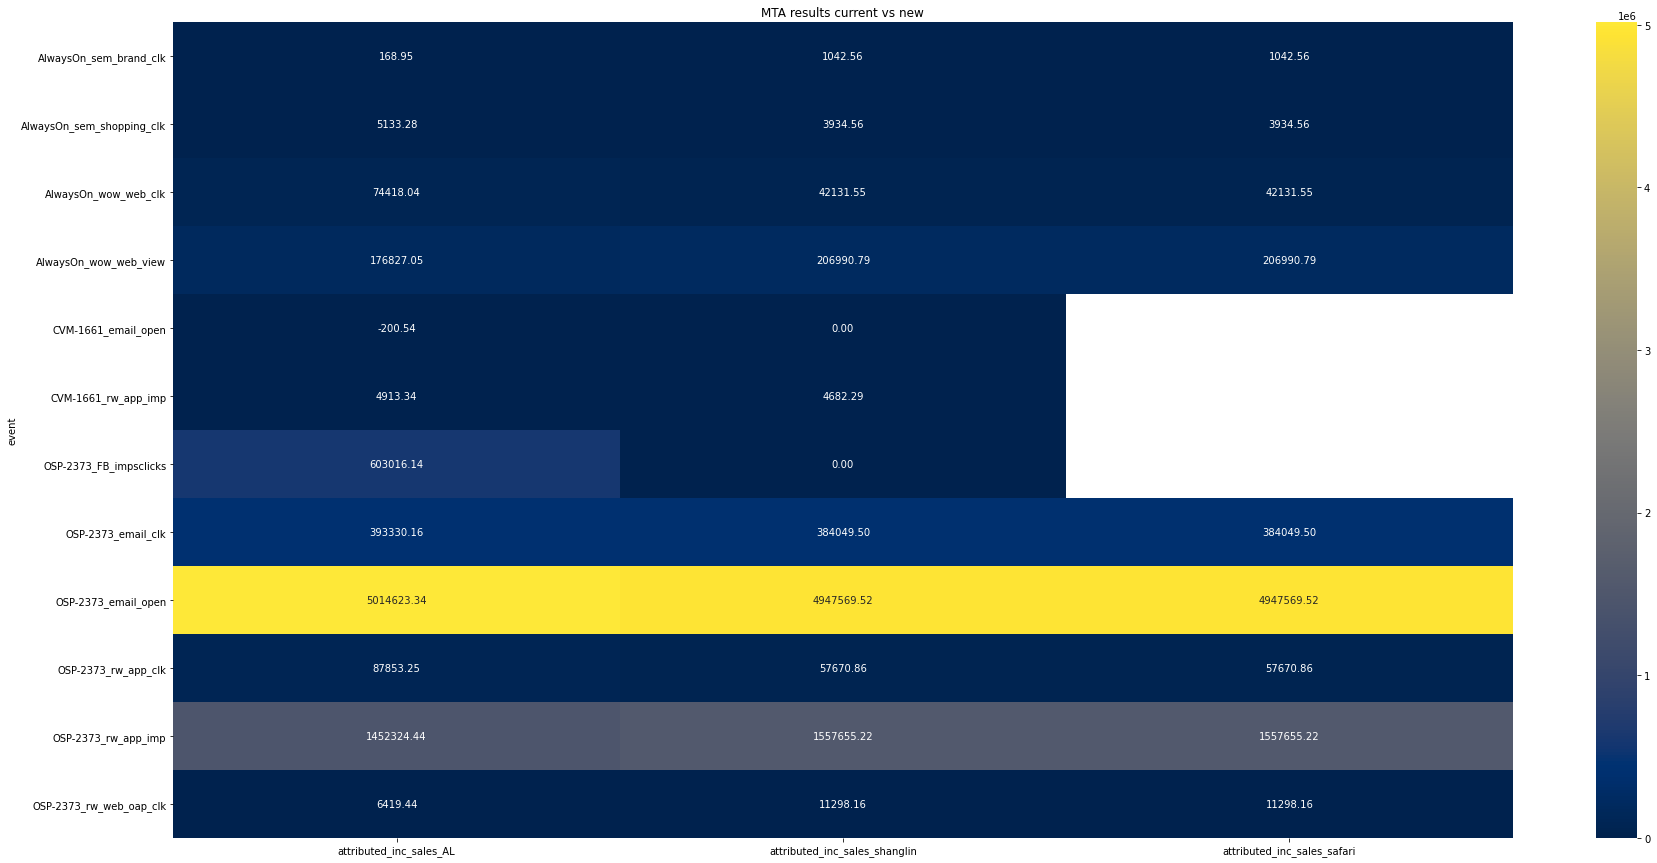

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000651                    0.003324   
AlwaysOn_sem_shopping_clk              0.002413                    0.014029   
AlwaysOn_wow_web_clk                   0.059943                    0.079322   
AlwaysOn_wow_web_view                  0.063872                    0.189427   
CVM-1661_email_open                    0.000896                    0.000000   
CVM-1661_rw_app_imp                    0.005464                    0.012382   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.189696                    0.381090   
OSP-2373_email_open                    0.238364                    0.648958   
OSP-2373_rw_app_clk                    0.081987                    0.096452   
OSP-2373_rw_app_imp                    0.341520                    0.510688   
OSP-2373_rw_web_oap_clk                0.014868                    0.064313   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                1.689451e+02   
AlwaysOn_sem_shopping_clk             5.133277e+03   
AlwaysOn_wow_web_clk                  7.441804e+04   
AlwaysOn_wow_web_view                 1.768271e+05   
CVM-1661_email_open                  -2.005389e+02   
CVM-1661_rw_app_imp                   4.913339e+03   
OSP-2373_FB_impsclicks                6.030161e+05   
OSP-2373_email_clk                    3.933302e+05   
OSP-2373_email_open                   5.014623e+06   
OSP-2373_rw_app_clk                   8.785325e+04   
OSP-2373_rw_app_imp                   1.452324e+06   
OSP-2373_rw_web_oap_clk               6.419440e+03   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      1.042565e+03   
AlwaysOn_sem_shopping_clk                   3.934558e+03   
AlwaysOn_wow_web_clk                        4.213155e+04   
AlwaysOn_wow_web_view                       2.069908e+05   
CVM-1661_email_open                         0.000000e+00   
CVM-1661_rw_app_imp                         4.682286e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          3.840495e+05   
OSP-2373_email_open                         4.947570e+06   
OSP-2373_rw_app_clk                         5.767086e+04   
OSP-2373_rw_app_imp                         1.557655e+06   
OSP-2373_rw_web_oap_clk                     1.129816e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    1.042565e+03  
AlwaysOn_sem_shopping_clk                 3.934558e+03  
AlwaysOn_wow_web_clk                      4.213155e+04  
AlwaysOn_wow_web_view                     2.069908e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        3.840495e+05  
OSP-2373_email_open                       4.947570e+06  
OSP-2373_rw_app_clk                       5.767086e+04  
OSP-2373_rw_app_imp                       1.557655e+06  
OSP-2373_rw_web_oap_clk                   1.129816e+04

In [64]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-03-29_2021-04-04_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-29",
                       safari_run_date="2021-04-08",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-22_OSP-2373`
>>> Step 3: Compare results to BAU run


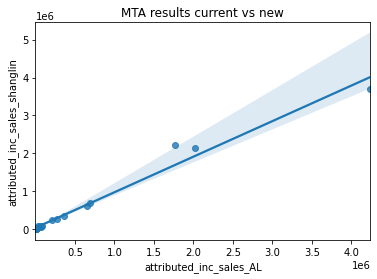

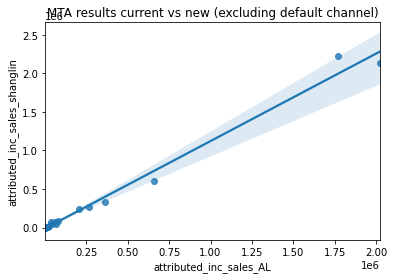

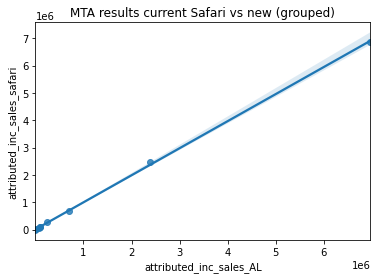

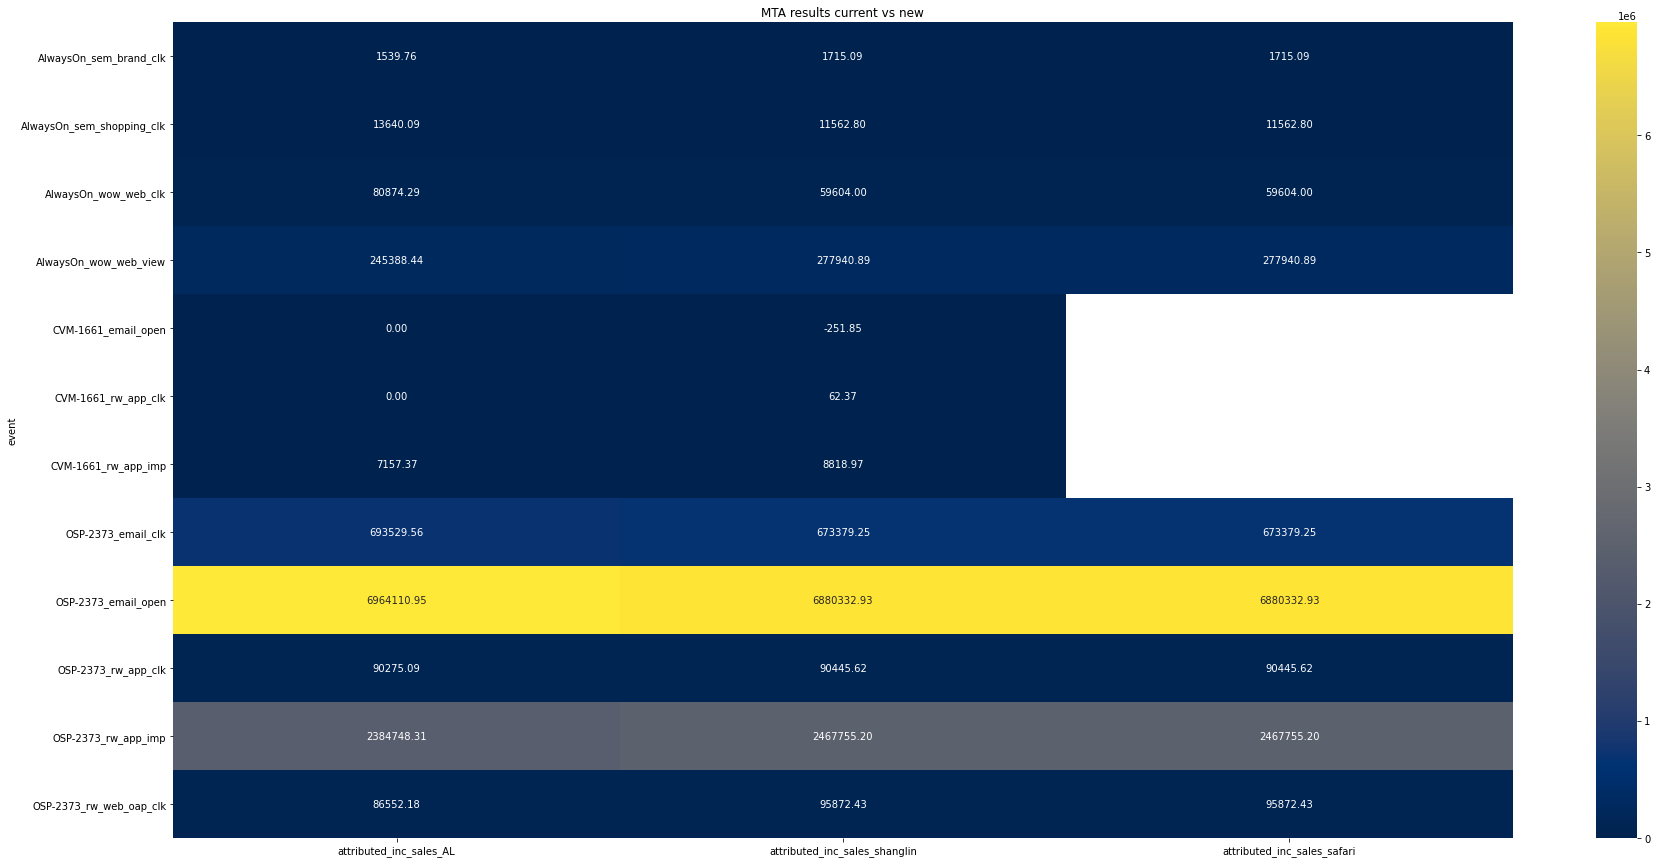

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-22 ... end of fw is 2021-03-28
	FB scaling ratio is (for missing slice of pie) 0.05664741032453099
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 0.056647410269178605
	touchpoint count increased by 509456
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-22_OSP-2373`


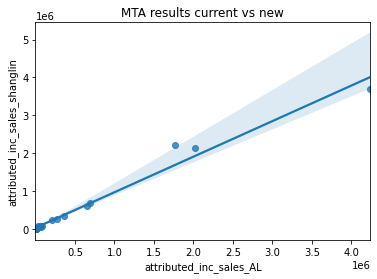

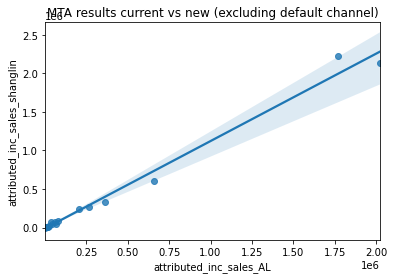

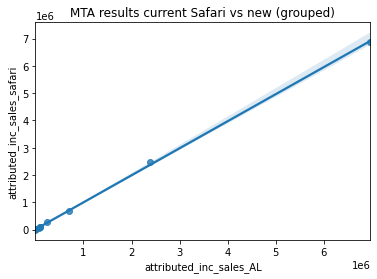

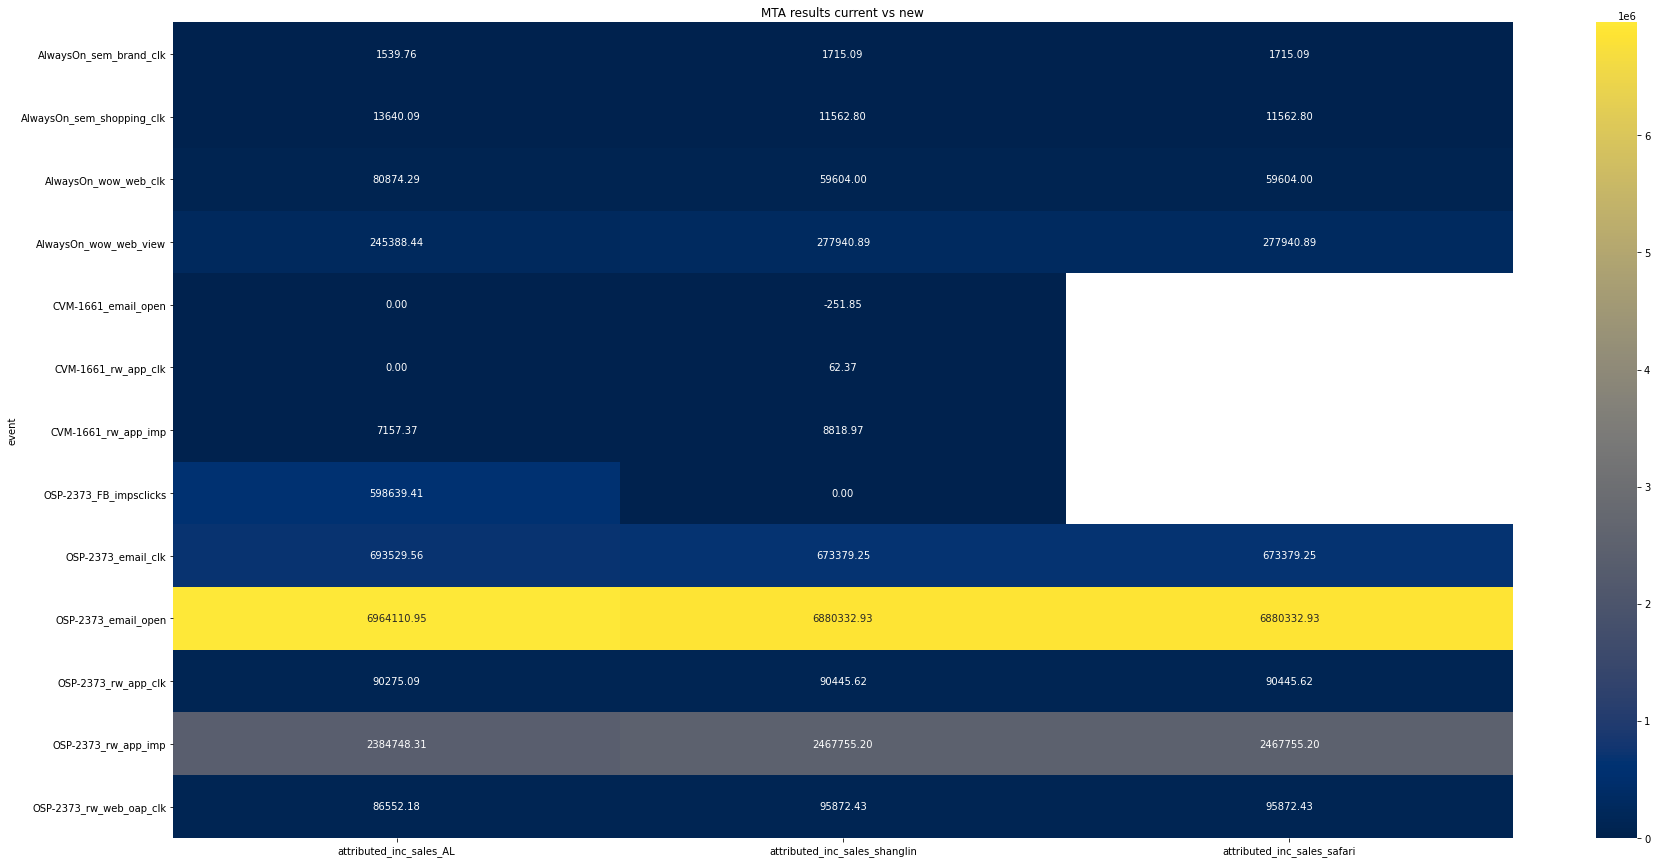

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_sem_brand_clk                 0.000152                    0.003626   
AlwaysOn_sem_shopping_clk              0.002142                    0.013307   
AlwaysOn_wow_web_clk                   0.036861                    0.080746   
AlwaysOn_wow_web_view                  0.050034                    0.176567   
CVM-1661_email_open                    0.000000                    0.001211   
CVM-1661_rw_app_clk                    0.000000                    0.003242   
CVM-1661_rw_app_imp                    0.006603                    0.028175   
OSP-2373_FB_impsclicks                -1.000000                    0.000000   
OSP-2373_email_clk                     0.216394                    0.392974   
OSP-2373_email_open                    0.250733                    0.712036   
OSP-2373_rw_app_clk                    0.069240                    0.080204   
OSP-2373_rw_app_imp                    0.356330                    0.436718   
OSP-2373_rw_web_oap_clk                0.011511                    0.071181   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_sem_brand_clk                1.539756e+03   
AlwaysOn_sem_shopping_clk             1.364009e+04   
AlwaysOn_wow_web_clk                  8.087429e+04   
AlwaysOn_wow_web_view                 2.453884e+05   
CVM-1661_email_open                   0.000000e+00   
CVM-1661_rw_app_clk                   0.000000e+00   
CVM-1661_rw_app_imp                   7.157369e+03   
OSP-2373_FB_impsclicks                5.986394e+05   
OSP-2373_email_clk                    6.935296e+05   
OSP-2373_email_open                   6.964111e+06   
OSP-2373_rw_app_clk                   9.027509e+04   
OSP-2373_rw_app_imp                   2.384748e+06   
OSP-2373_rw_web_oap_clk               8.655218e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_sem_brand_clk                      1.715093e+03   
AlwaysOn_sem_shopping_clk                   1.156280e+04   
AlwaysOn_wow_web_clk                        5.960400e+04   
AlwaysOn_wow_web_view                       2.779409e+05   
CVM-1661_email_open                        -2.518513e+02   
CVM-1661_rw_app_clk                         6.236507e+01   
CVM-1661_rw_app_imp                         8.818968e+03   
OSP-2373_FB_impsclicks                      0.000000e+00   
OSP-2373_email_clk                          6.733792e+05   
OSP-2373_email_open                         6.880333e+06   
OSP-2373_rw_app_clk                         9.044562e+04   
OSP-2373_rw_app_imp                         2.467755e+06   
OSP-2373_rw_web_oap_clk                     9.587243e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_sem_brand_clk                    1.715093e+03  
AlwaysOn_sem_shopping_clk                 1.156280e+04  
AlwaysOn_wow_web_clk                      5.960400e+04  
AlwaysOn_wow_web_view                     2.779409e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_clk                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_FB_impsclicks                             NaN  
OSP-2373_email_clk                        6.733792e+05  
OSP-2373_email_open                       6.880333e+06  
OSP-2373_rw_app_clk                       9.044562e+04  
OSP-2373_rw_app_imp                       2.467755e+06  
OSP-2373_rw_web_oap_clk                   9.587243e+04

In [69]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-03-22_2021-03-28_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-22",
                       safari_run_date="2021-03-31",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

>>> Step 1: convert MC results to post MTA_format and upload to BQ
	removing facebook touchpoints from MC output
	df generated for upload to BQ
	post MTA output uploaded to BQ
>>> Step 2: run post MTA processing (Shanglin's process)
	exported to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_2021-03-15_OSP-2373`
>>> Step 3: Compare results to BAU run


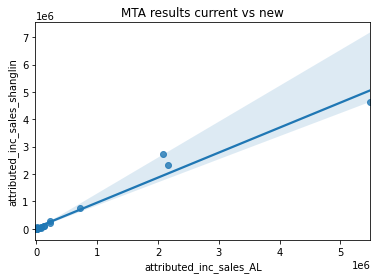

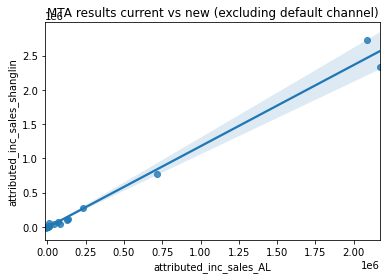

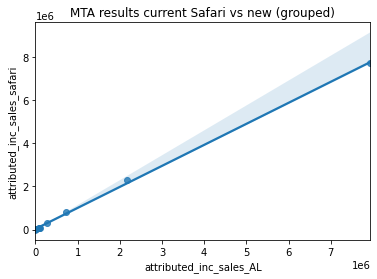

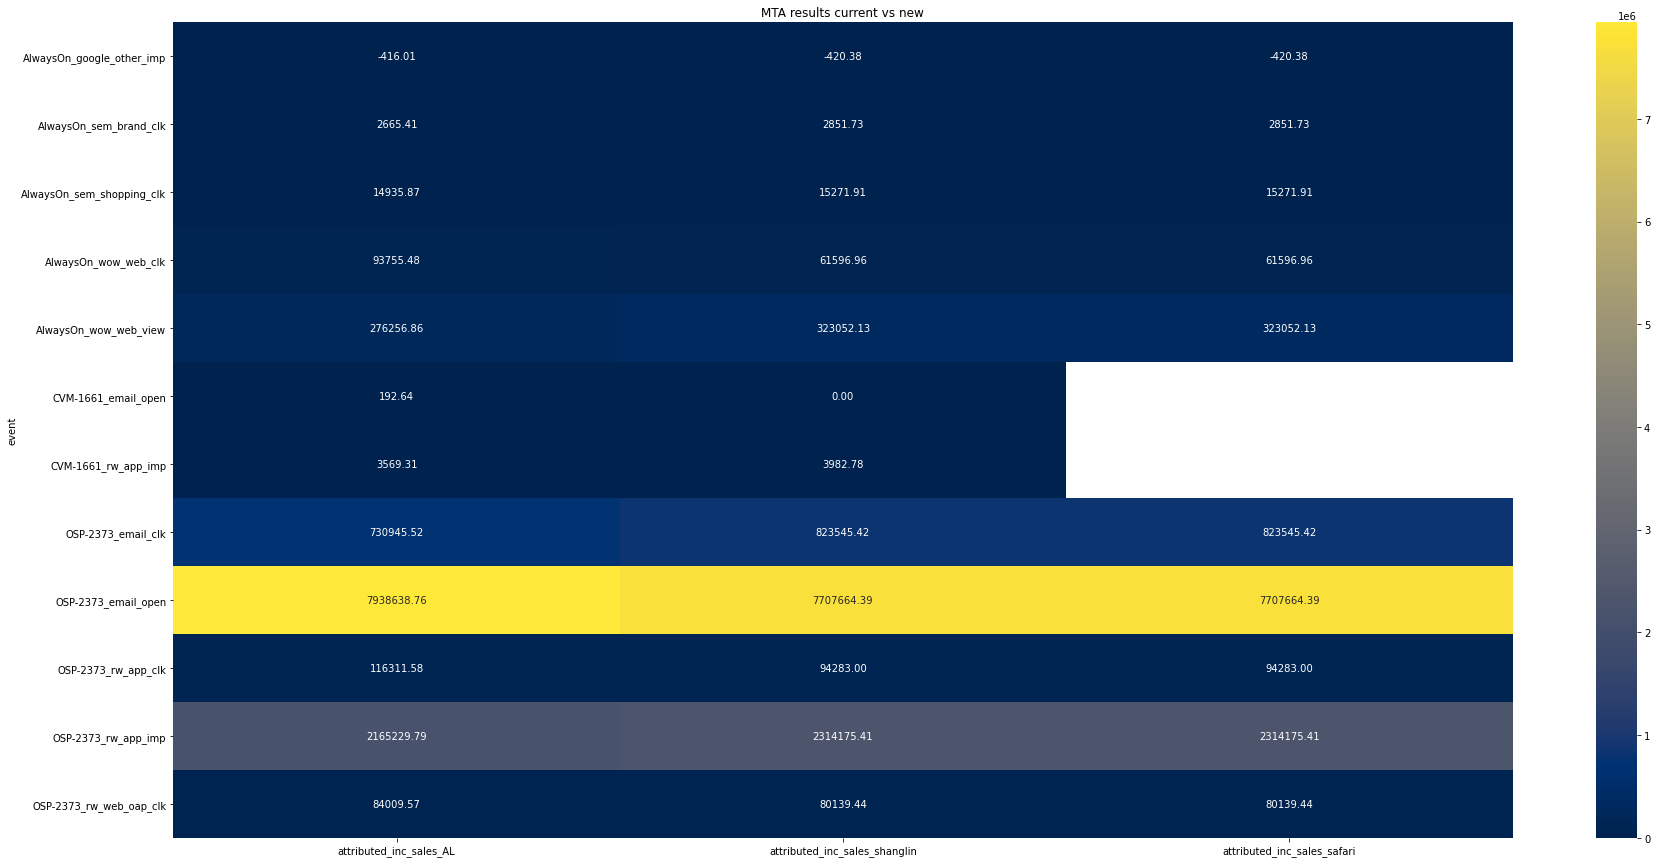

>>> Step 4 (only for fws with FB): Distribute FB inc sales
2021-03-15 ... end of fw is 2021-03-21
	FB scaling ratio is (for missing slice of pie) 0.0
WARNING... FB scaling ratio is outside normal range of values
	fb inc sales for OSP-2373 increased by 1.0498280476418049e-13
	touchpoint count increased by 484330
	exported dacamp_prod_mc_final_crn_w_fb to `wx-bq-poc.personal.AL_FBAA_MC_dacamp_prod_mc_final_crn_w_fb_2021-03-15_OSP-2373`


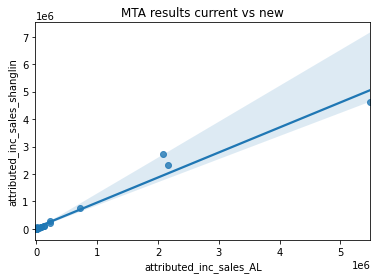

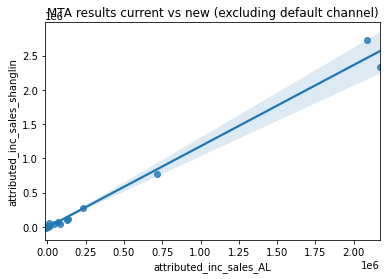

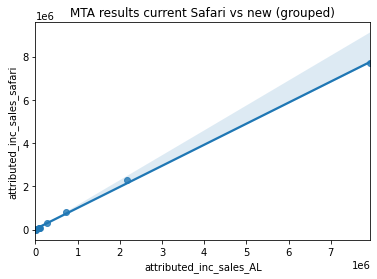

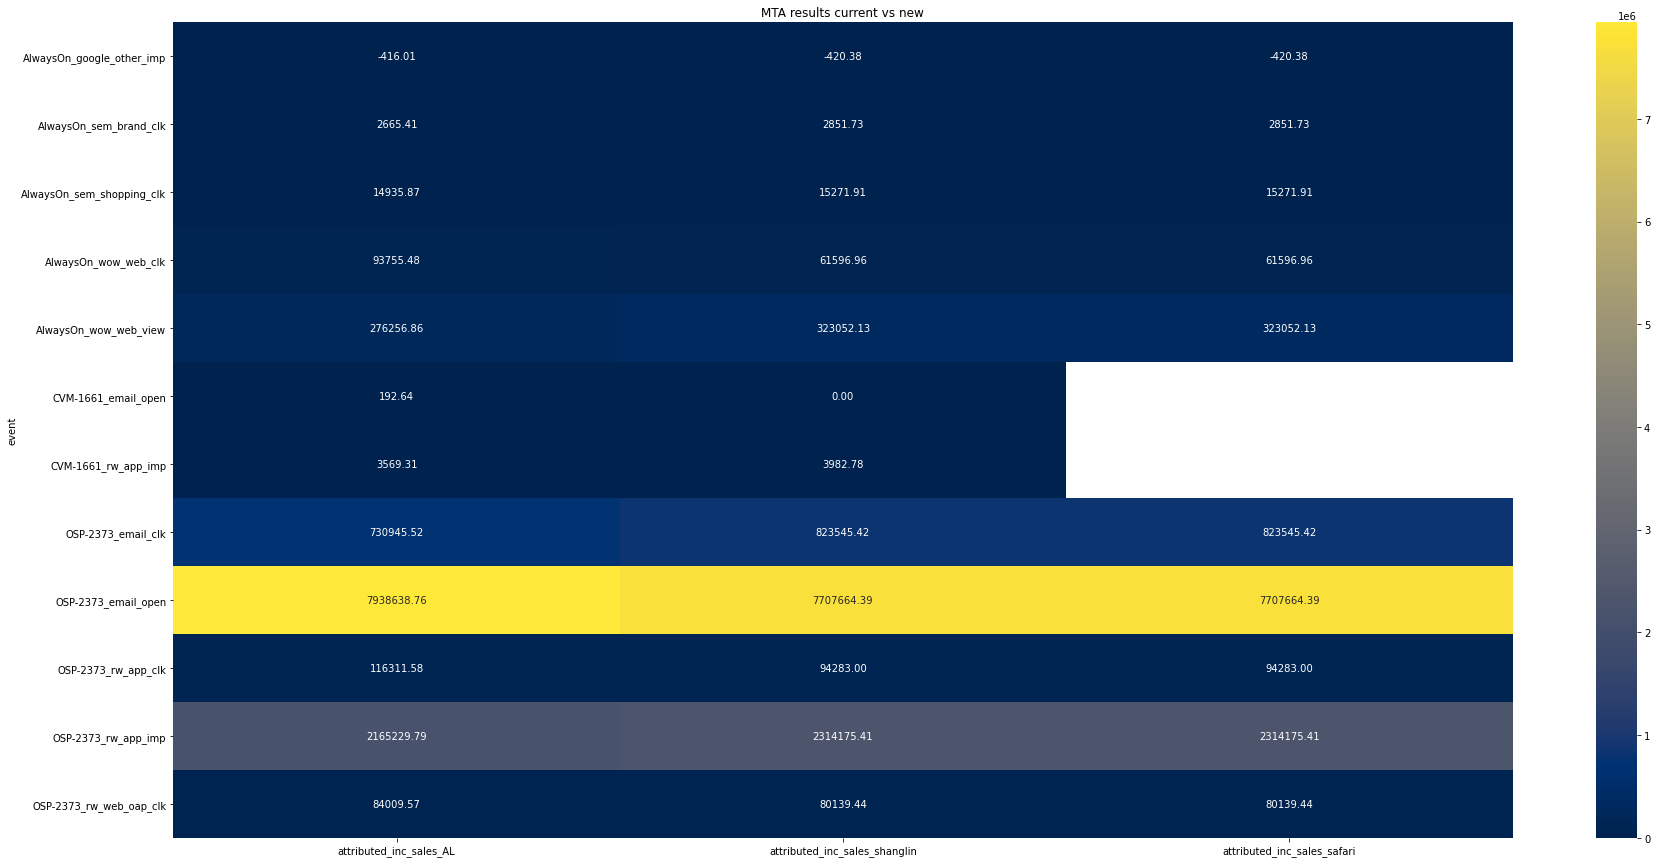

channel_prob_norm_AL  channel_prob_norm_shanglin  \
event                                                                         
AlwaysOn_google_other_imp              0.000112                    0.001275   
AlwaysOn_sem_brand_clk                 0.000134                    0.004582   
AlwaysOn_sem_shopping_clk              0.003817                    0.014233   
AlwaysOn_wow_web_clk                   0.036805                    0.085127   
AlwaysOn_wow_web_view                  0.044404                    0.172724   
CVM-1661_email_open                    0.000427                    0.000000   
CVM-1661_rw_app_imp                    0.003439                    0.006257   
OSP-2373_email_clk                     0.224773                    0.418362   
OSP-2373_email_open                    0.269456                    0.721155   
OSP-2373_rw_app_clk                    0.085949                    0.077263   
OSP-2373_rw_app_imp                    0.314194                    0.448739   
OSP-2373_rw_web_oap_clk                0.016489                    0.050269   

                           attributed_inc_sales_AL  \
event                                                
AlwaysOn_google_other_imp            -4.160111e+02   
AlwaysOn_sem_brand_clk                2.665411e+03   
AlwaysOn_sem_shopping_clk             1.493587e+04   
AlwaysOn_wow_web_clk                  9.375548e+04   
AlwaysOn_wow_web_view                 2.762569e+05   
CVM-1661_email_open                   1.926368e+02   
CVM-1661_rw_app_imp                   3.569311e+03   
OSP-2373_email_clk                    7.309455e+05   
OSP-2373_email_open                   7.938639e+06   
OSP-2373_rw_app_clk                   1.163116e+05   
OSP-2373_rw_app_imp                   2.165230e+06   
OSP-2373_rw_web_oap_clk               8.400957e+04   

                           attributed_inc_sales_shanglin  \
event                                                      
AlwaysOn_google_other_imp                  -4.203830e+02   
AlwaysOn_sem_brand_clk                      2.851732e+03   
AlwaysOn_sem_shopping_clk                   1.527191e+04   
AlwaysOn_wow_web_clk                        6.159696e+04   
AlwaysOn_wow_web_view                       3.230521e+05   
CVM-1661_email_open                         0.000000e+00   
CVM-1661_rw_app_imp                         3.982777e+03   
OSP-2373_email_clk                          8.235454e+05   
OSP-2373_email_open                         7.707664e+06   
OSP-2373_rw_app_clk                         9.428300e+04   
OSP-2373_rw_app_imp                         2.314175e+06   
OSP-2373_rw_web_oap_clk                     8.013944e+04   

                           attributed_inc_sales_safari  
event                                                   
AlwaysOn_google_other_imp                -4.203830e+02  
AlwaysOn_sem_brand_clk                    2.851732e+03  
AlwaysOn_sem_shopping_clk                 1.527191e+04  
AlwaysOn_wow_web_clk                      6.159696e+04  
AlwaysOn_wow_web_view                     3.230521e+05  
CVM-1661_email_open                                NaN  
CVM-1661_rw_app_imp                                NaN  
OSP-2373_email_clk                        8.235454e+05  
OSP-2373_email_open                       7.707664e+06  
OSP-2373_rw_app_clk                       9.428300e+04  
OSP-2373_rw_app_imp                       2.314175e+06  
OSP-2373_rw_web_oap_clk                   8.013944e+04

In [70]:
run_downstream_process(fpath_results="01_results/res_w_fb_weighted_OSP-2373_2021-03-15_2021-03-21_7.csv",
                       BQ_output_suffix="OSP-2373",
                       campaign_code="OSP-2373",
                       fw="2021-03-15",
                       safari_run_date="2021-03-24",
                       create_dacamp_prod_mc_final=True,
                       have_historical_marketable_crn=False,
                       which_mc_crn_output="Weixing",
                       allocate_fb=True,
                       fpath_comparison_results="02_comparison/res_w_fb_weighted")

In [ ]:
2+2